# MSIN0114 Dissertation - Predicting customer satisfaction in Olist

### Submission date: 17/8/2020



## Business overview

Olist provides an online e-commerce site platform that is based in Brazil snice 2015. It connects small businesses and entrepreneurs all around Brazil which allow merchants to sell products on larger marketplaces such as Amazon. The dataset is a real commercial data that included informaton of 100k orders between 2016 to 2018 with different dimensions.

## Objective

This dissertation project is aimed to predict customer satisfaction rate based on customer historical purchasing records. It aimed to have a better understanding of customer satisfaction rate in order to increase sales of merchants in Olist. In order to achieve the aim, this dissertation first conduct an exploratory  data analysis to understand relationships and trends between variables, then generated four quantifiable measurements under four features categories that are efficient on assessing customer satisfaction, different predictive models will be implemented to predict customer satisfaction. 

## 1. Import data

In [1]:
# Interactivity
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import library
import pandas as pd
import numpy as np
import seaborn as sns

# For Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import matplotlib.ticker as mtick

# For encoding
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# For calculation
from math import radians, cos, sin, asin, sqrt

# For PCA features
from sklearn import decomposition

from functools import reduce

In [2]:
pip install sklearn-pandas==1.5.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import datasets that are relevent based on the disertation's objective
customer_df = pd.read_csv('/Users/debbielauyt/Desktop/dissertation/brazilian-ecommerce/olist_customers_dataset.csv', header = [0])
location_df = pd.read_csv('/Users/debbielauyt/Desktop/dissertation/brazilian-ecommerce/olist_geolocation_dataset.csv', header = [0])
orders_items_df = pd.read_csv('/Users/debbielauyt/Desktop/dissertation/brazilian-ecommerce/olist_order_items_dataset.csv', header = [0])
payments_df = pd.read_csv('/Users/debbielauyt/Desktop/dissertation/brazilian-ecommerce/olist_order_payments_dataset.csv', header = [0])
reviews_df = pd.read_csv('/Users/debbielauyt/Desktop/dissertation/brazilian-ecommerce/olist_order_reviews_dataset.csv', header = [0])
orders_df = pd.read_csv('/Users/debbielauyt/Desktop/dissertation/brazilian-ecommerce/olist_orders_dataset.csv', header = [0])
products_df = pd.read_csv('/Users/debbielauyt/Desktop/dissertation/brazilian-ecommerce/olist_products_dataset.csv', header = [0])
sellers_df = pd.read_csv('/Users/debbielauyt/Desktop/dissertation/brazilian-ecommerce/olist_sellers_dataset.csv', header = [0])
product_cat_trans = pd.read_csv('/Users/debbielauyt/Desktop/dissertation/brazilian-ecommerce/product_category_name_translation.csv', header = [0])

## 2. Data Overview

The data is seperated in multiples datasets for better organisation. Please refer to the following data schema for better understanding:

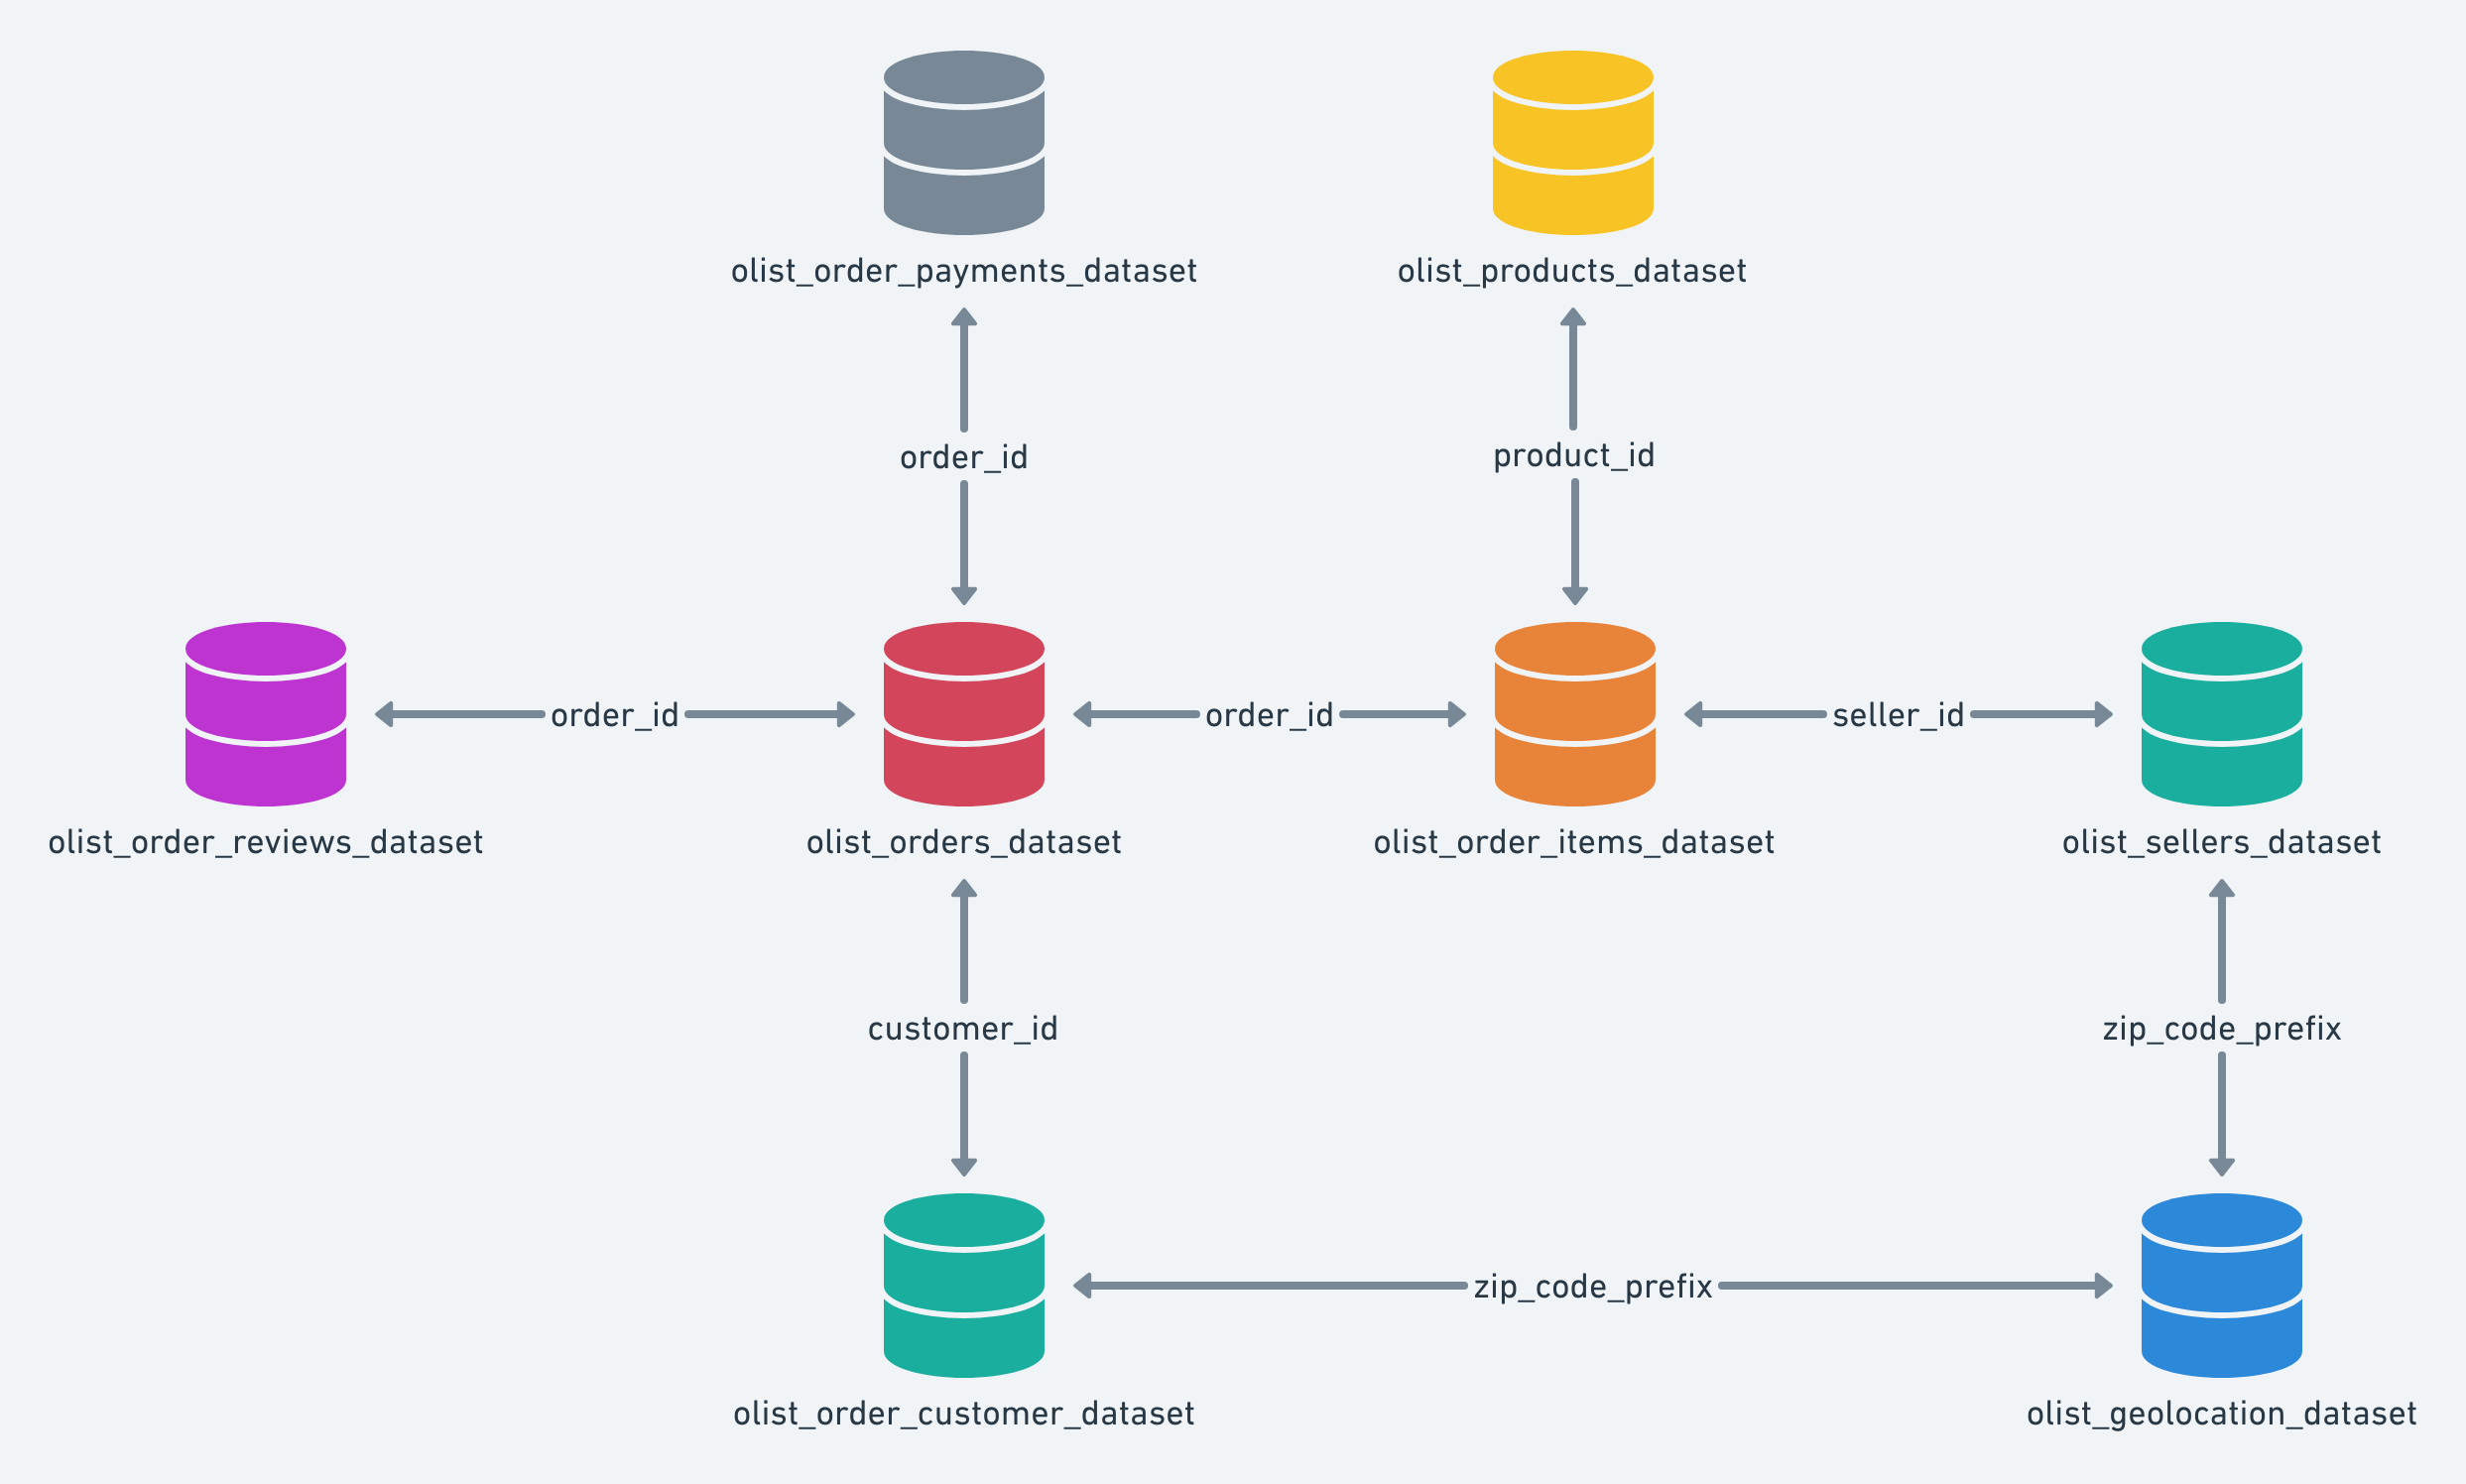

In [4]:
Image(filename='/Users/debbielauyt/Desktop/dissertation/HRhd2Y0.png')

In [5]:
# Data info
data = [customer_df, location_df, orders_items_df, payments_df, reviews_df, orders_df, \
                products_df, sellers_df, product_cat_trans]
for i in data:
    i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
customer_id                 99441 non-null object
customer_unique_id          99441 non-null object
customer_zip_code_prefix    99441 non-null int64
customer_city               99441 non-null object
customer_state              99441 non-null object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
geolocation_zip_code_prefix    1000163 non-null int64
geolocation_lat                1000163 non-null float64
geolocation_lng                1000163 non-null float64
geolocation_city               1000163 non-null object
geolocation_state              1000163 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
order_id               112650 no

## 3. Data cleaning

### a. Language translation
Since the data is from Brazil, it is in Portuguese. Therefore, translation to english is essential for product categories. 

In [6]:
# Change product category name into english
products_df = products_df.reset_index()
products_df = products_df.merge(product_cat_trans, on = 'product_category_name')
products_df = products_df.drop('product_category_name', axis = 1)
products_df = products_df.sort_values(by = ['index'])
products_df = products_df.set_index('index')
products_df = products_df.rename(columns = {'product_category_name_english':'product_category'})
products_df['product_category'].head()

index
0         perfumery
1               art
2    sports_leisure
3              baby
4        housewares
Name: product_category, dtype: object

### b. Generate total price
Customers may order multiple items under the same order. Therefore, calculation of total price is needed in one single order for further analysis. 

In [7]:
# One of the customer had ordered one single product three times under one order
orders_items_df[orders_items_df['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


In [8]:
# Get the total price
orders_items_df = orders_items_df.drop_duplicates('order_id', keep = 'last')
orders_items_df['total_price'] = orders_items_df['price'] * orders_items_df['order_item_id'] 

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
orders_items_df[orders_items_df['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_price
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,63.99


### C. Location
Based on the map below, it is shown that majority of orders are loated within Brazil since OList is a Brazilian-based company. In this dissertation, data will be limited to orders within Brazil.

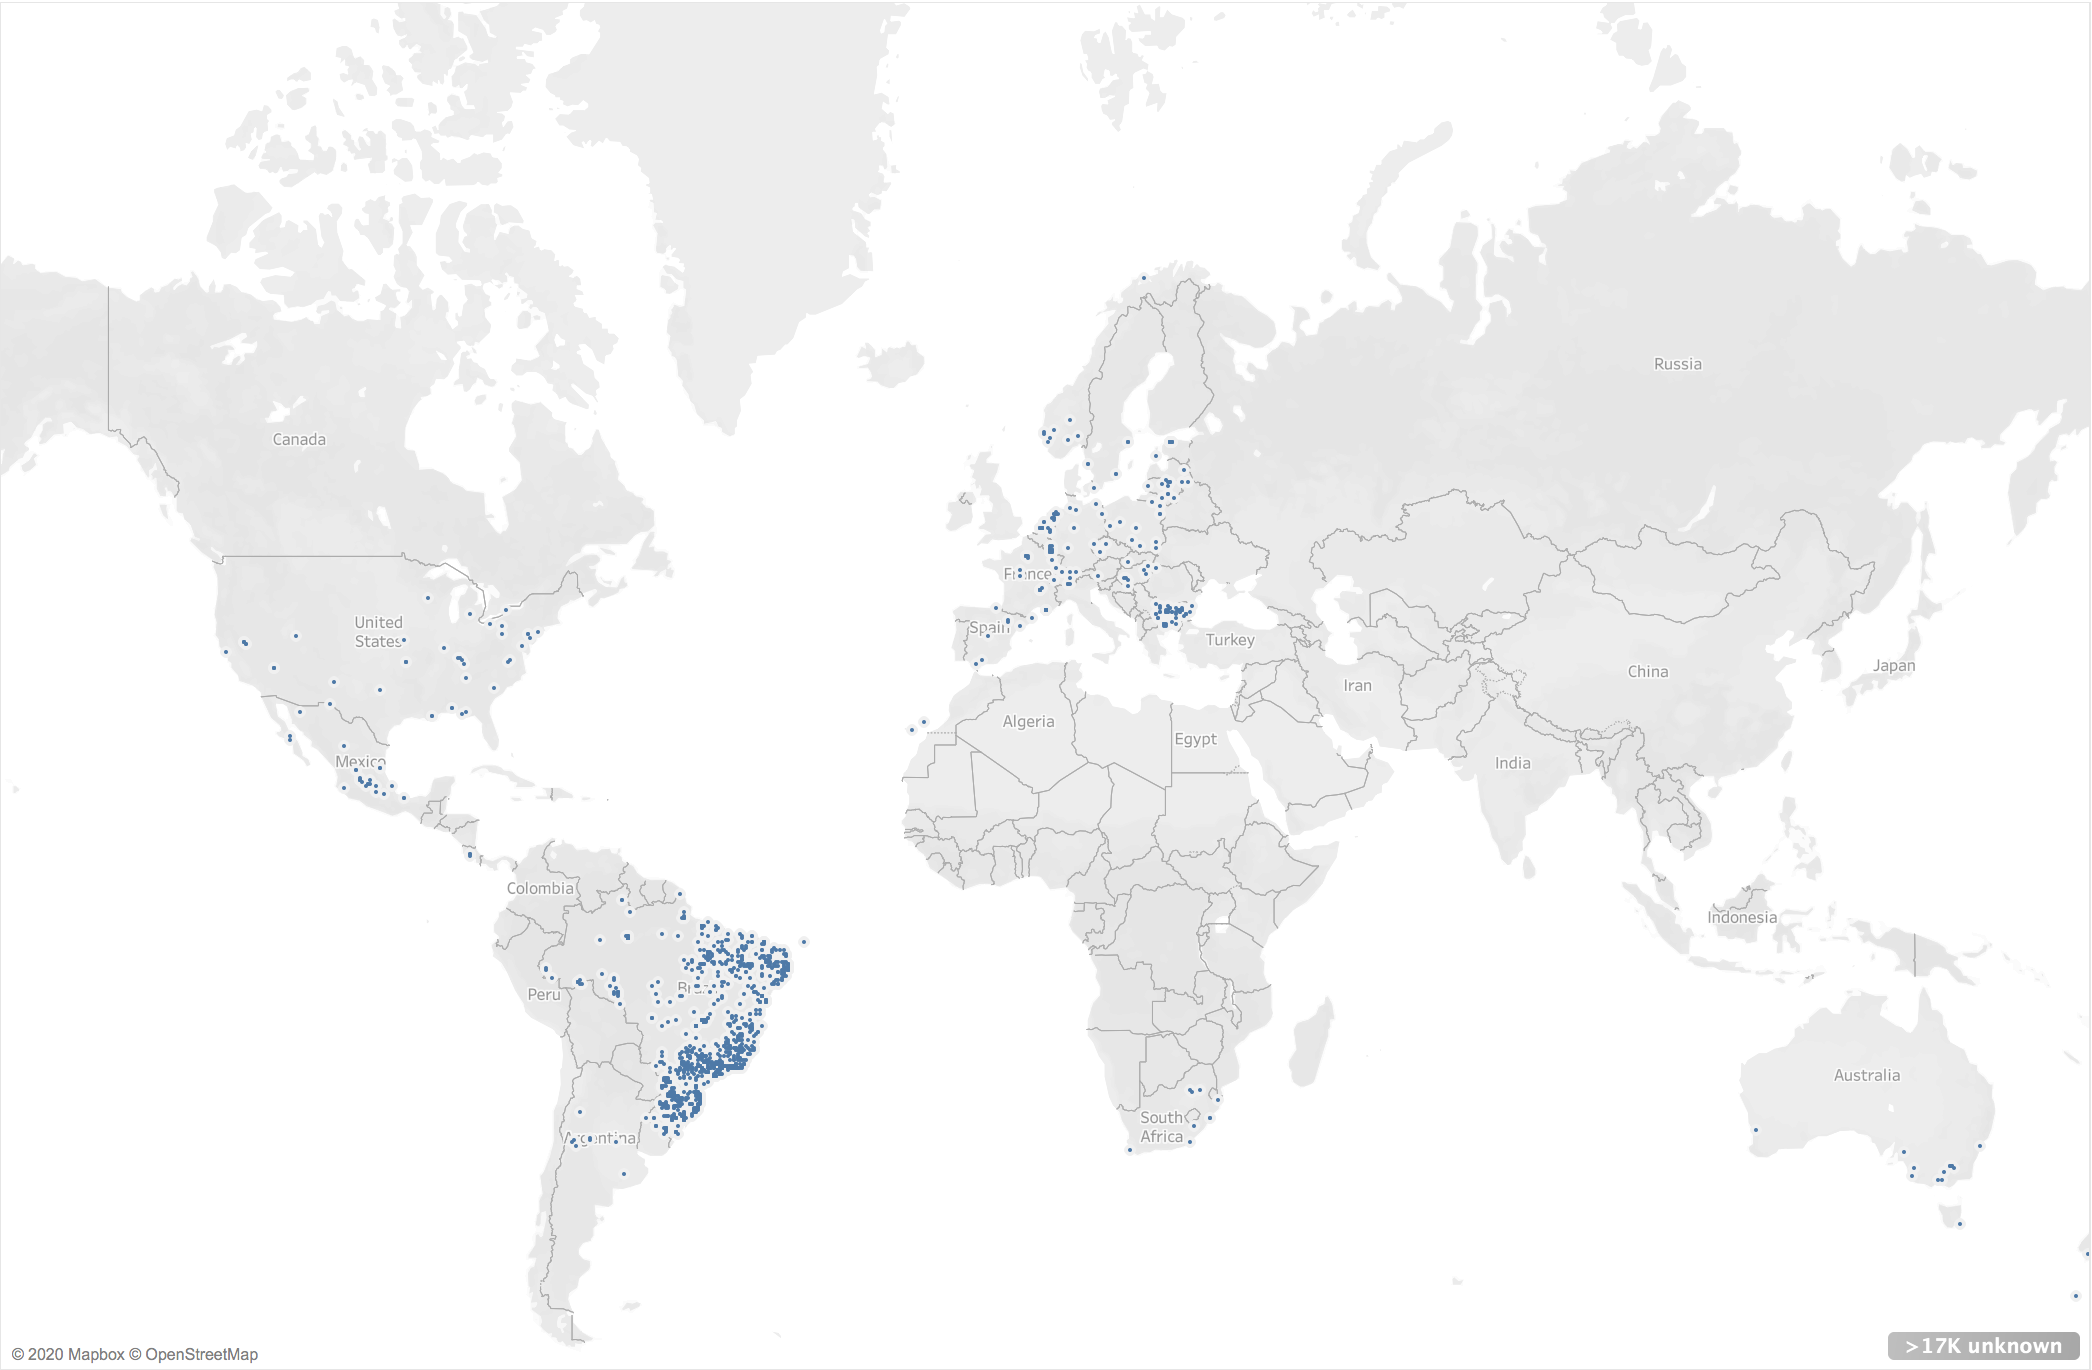

In [10]:
Image(filename='/Users/debbielauyt/Desktop/dissertation/geolocation_map.png')

The figure above shows the distribution of orders in the world. 

In [11]:
# Limit orders that are within Brazil
brazil_orders = location_df[location_df['geolocation_lat'] <= 5.27438888]
brazil_orders = location_df[location_df['geolocation_lng'] >= -73.98283055]
brazil_orders = location_df[location_df['geolocation_lat'] >= -33.75116944]
brazil_orders = location_df[location_df['geolocation_lng'] <= -34.79314722]

In [12]:
brazil_orders.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


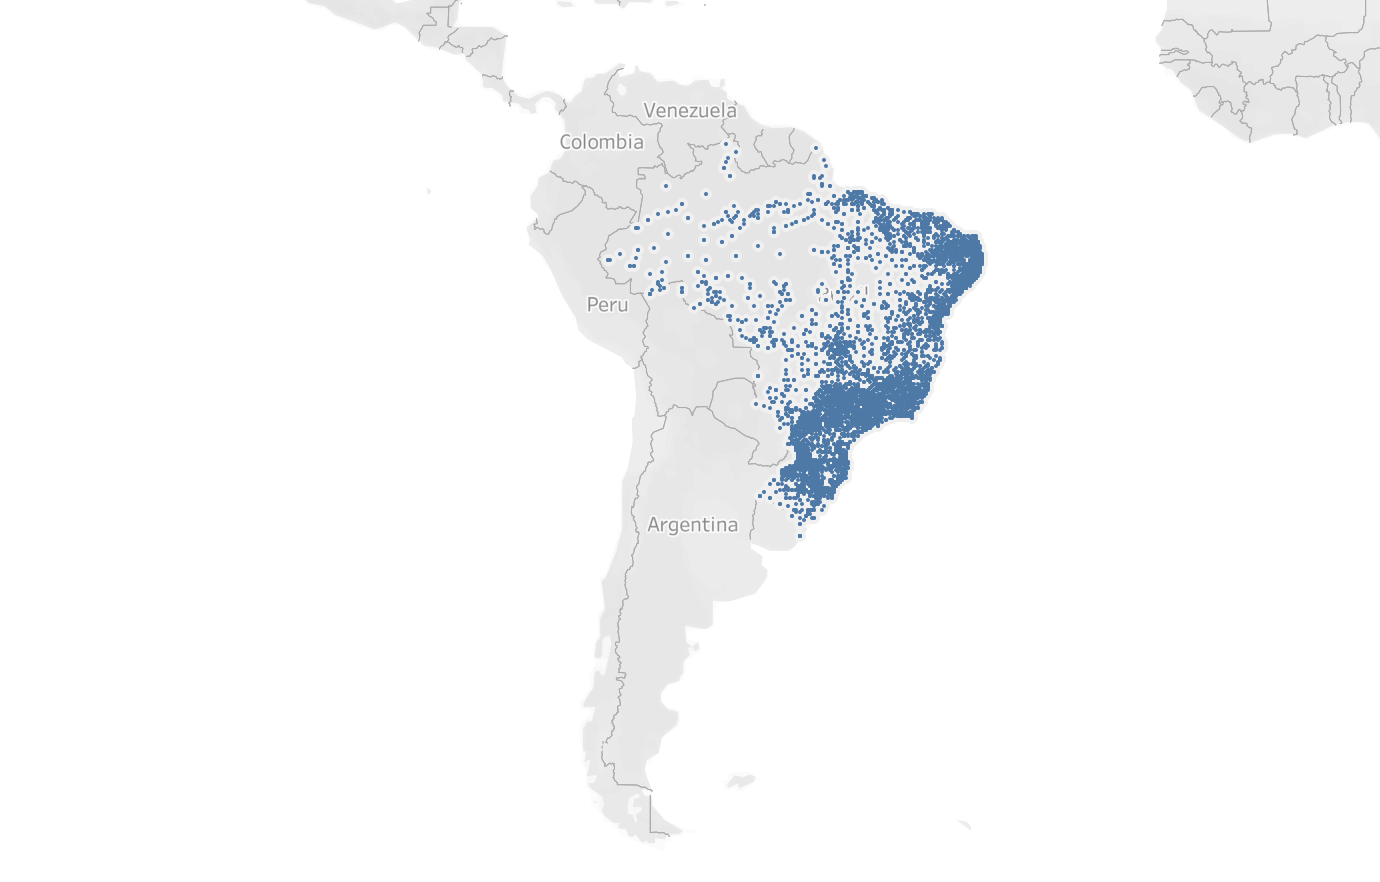

In [13]:
Image(filename='/Users/debbielauyt/Desktop/dissertation/geolocation_brazil.png')

Now, all the dataset will be cleaned and reduced within Brazil.There are a total of 6 dataset that will be used in this project. All dataset will be combined into one whole data for better exploration. 

In [14]:
# Reduce dataset that are within Brazil 
customer_df = customer_df[customer_df.customer_zip_code_prefix.isin(brazil_orders.geolocation_zip_code_prefix)]
orders_df = orders_df[orders_df.customer_id.isin(customer_df.customer_id)]
orders_items_df = orders_items_df[orders_items_df.order_id.isin(orders_df.order_id)]
reviews_df = reviews_df[reviews_df.order_id.isin(orders_items_df.order_id)]
products_df = products_df[products_df.product_id.isin(orders_items_df.product_id)]
sellers_df = sellers_df[sellers_df.seller_id.isin(orders_items_df.seller_id)]
payments_df = payments_df[payments_df.order_id.isin(orders_df.order_id)]
location_df = brazil_orders.copy()

In [15]:
# Rename columns name
location_df = location_df.rename(columns = {'geolocation_zip_code_prefix' : 'zip_code_prefix'})
customer_df = customer_df.rename(columns = {'customer_zip_code_prefix' : 'zip_code_prefix'})
sellers_df = sellers_df.rename(columns = {'seller_zip_code_prefix' : 'zip_code_prefix'})

In [16]:
# Merge customer_df with location_df 
customer_df = customer_df.merge(location_df, on = 'zip_code_prefix').drop_duplicates(subset = 'customer_id', keep = 'first')\
                                .reset_index(drop = True)
customer_df = customer_df.rename(columns = {'geolocation_lat':'customer_lat', 'geolocation_lng':'customer_lng', 
                                    'zip_code_prefix':'customer_zip_code_prefix'})
customer_df = customer_df[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 
                           'customer_city', 'customer_state', 'customer_lat', 'customer_lng']]

In [17]:
# Merge sellers_df with location_df
sellers_df = sellers_df.merge(location_df, on = 'zip_code_prefix').drop_duplicates(subset = 'seller_id', keep = 'first').reset_index(drop = True)
sellers_df = sellers_df.rename(columns = {'geolocation_lat':'seller_lat', 'geolocation_lng':'seller_lng',
                                             'zip_code_prefix':'seller_zip_code_prefix'})
sellers_df = sellers_df[['seller_id','seller_zip_code_prefix','seller_city','seller_state','seller_lat','seller_lng']]

In [18]:
# Combine all dataset into one dataframe
df = customer_df.merge(orders_df, on = 'customer_id')
df = df.merge(orders_items_df, on = 'order_id')
df = df.merge(reviews_df, on = 'order_id')
df = df.merge(products_df, on = 'product_id')
df = df.merge(sellers_df, on = 'seller_id')

In [19]:
# Get all columns that are relevant
df = df[['order_id', 'customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'customer_lat', 'customer_lng',
        'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'total_price', 'review_score',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'product_category',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'seller_lat', 
       'seller_lng']]

In [20]:
# drop all duplicated rows
df = df.drop_duplicates(subset = 'order_id', keep = 'first')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96741 entries, 0 to 97281
Data columns (total 35 columns):
order_id                         96741 non-null object
customer_id                      96741 non-null object
customer_unique_id               96741 non-null object
customer_zip_code_prefix         96741 non-null int64
customer_city                    96741 non-null object
customer_state                   96741 non-null object
customer_lat                     96741 non-null float64
customer_lng                     96741 non-null float64
order_status                     96741 non-null object
order_purchase_timestamp         96741 non-null object
order_approved_at                96728 non-null object
order_delivered_carrier_date     95773 non-null object
order_delivered_customer_date    94624 non-null object
order_estimated_delivery_date    96741 non-null object
order_item_id                    96741 non-null int64
product_id                       96741 non-null object
seller_id  

## 4. Descriptive analysis

### a. Review score

### i. Total number of reviews

In [650]:
print('There is a total of', df.review_score.count(), 'reviews.')

There is a total of 96741 reviews.


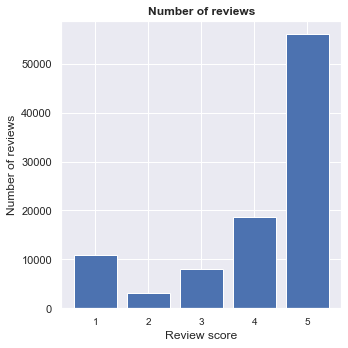

In [651]:
# Number of reviews
review_counts = df['review_score'].value_counts().sort_index()

fig = plt.gcf()
fig.set_size_inches(5,5)
n_groups = len(review_counts.keys())
index = np.arange(n_groups)

plt.bar(index, review_counts)
plt.title('Number of reviews', fontweight="bold", size=12)
plt.xlabel('Review score')
plt.ylabel('Number of reviews')
plt.xticks(index, review_counts.keys())
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show();

### ii. Mean price value by review score

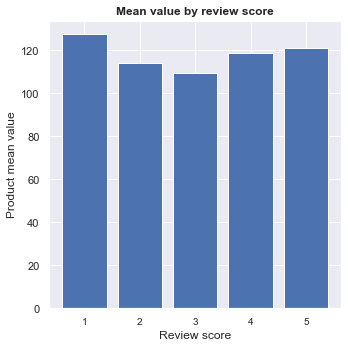

In [652]:
# mean price value by review score
review_values = reviews_df.merge(orders_items_df, on = 'order_id')
total_value = review_values.groupby('review_score')['total_price'].sum()
no_of_reviews = review_values.groupby('review_score')['order_item_id'].sum()
value_by_review_score = total_value/no_of_reviews

fig = plt.gcf()
fig.set_size_inches(5,5)
n_groups = len(value_by_review_score.keys())
index = np.arange(n_groups)

plt.bar(index, value_by_review_score)
plt.title('Mean value by review score', fontweight="bold", size=12)
plt.xlabel('Review score')
plt.ylabel('Product mean value')
plt.xticks(index, value_by_review_score.keys())
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show();

### b. Demographic location

In [653]:
print ('There is total of',  df.customer_unique_id.nunique(), 'unique customers and',\
       df.seller_id.nunique(), 'of unique sellers in Brazil.')

There is total of 93598 unique customers and 3016 of unique sellers in Brazil.


### i. Number of customers and sellers by state

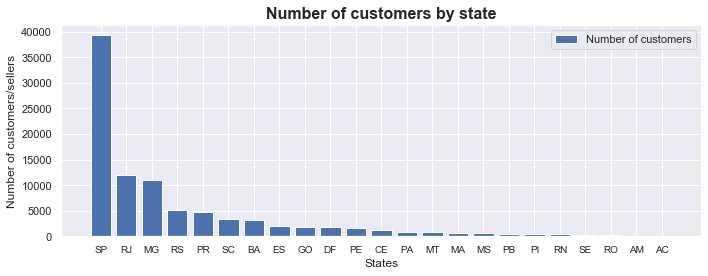

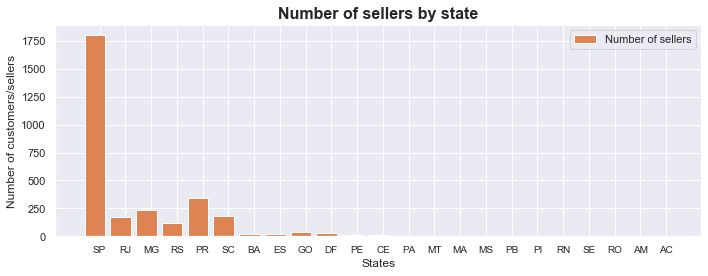

In [654]:
# Number of customers and sellers by state
customer_state = df.groupby('customer_state')['customer_unique_id'].nunique().sort_values(ascending = False).to_frame().reset_index().rename(columns = {'customer_state':'state'})
seller_state = df.groupby('seller_state')['seller_id'].nunique().sort_values(ascending = False).to_frame().reset_index().rename(columns = {'seller_state':'state'})
state_count = customer_state.merge(seller_state, on = 'state').set_index('state')

# Plot number of customers by state
fig = plt.gcf()
fig.set_size_inches(10,4)
n_groups_1 = len(state_count['customer_unique_id'].keys())
index_1 = np.arange(n_groups_1)

plt.bar(index_1, state_count['customer_unique_id'], label = 'Number of customers')
plt.title('Number of customers by state', fontweight="bold", size=16)
plt.xlabel('States')
plt.ylabel('Number of customers/sellers')
plt.xticks(index_1, state_count['customer_unique_id'].keys())
plt.xticks(fontsize=10)
plt.legend()
plt.tight_layout()
plt.show();

# Plot number of sellers by state
fig = plt.gcf()
fig.set_size_inches(10,4)
n_groups_2 = len(state_count['seller_id'].keys())
index_2 = np.arange(n_groups_2)

plt.bar(index_2, state_count['seller_id'], label = 'Number of sellers', color= 'C1')
plt.title('Number of sellers by state', fontweight="bold", size=16)
plt.xlabel('States')
plt.ylabel('Number of customers/sellers')
plt.xticks(index_1+0.18, state_count['seller_id'].keys())
plt.xticks(fontsize=10)
plt.legend()
plt.tight_layout()
plt.show();

In [655]:
# Top 3 states that contains the most customers/ sellers
customer_state['customer_state_pct'] = customer_state['customer_unique_id']/customer_state['customer_unique_id'].sum()
seller_state['seller_state_pct'] = seller_state['seller_id']/seller_state['seller_id'].sum()
customer_state.head()[:3]
seller_state.head()[:3]

,state,customer_unique_id,customer_state_pct
0,SP,39345,0.420195
1,RJ,12068,0.128883
2,MG,10981,0.117275


,state,seller_id,seller_state_pct
0,SP,1803,0.597812
1,PR,342,0.113395
2,MG,234,0.077586


### ii. Customer's spending and seller's revenue by state

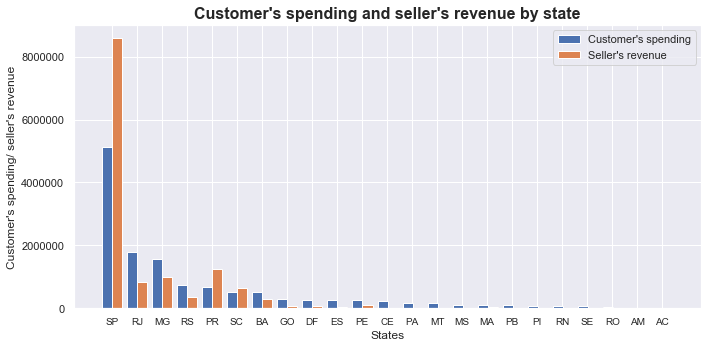

In [656]:
# Customer's spending and seller's revenue by state
customer_spending = df.groupby('customer_state')['total_price'].sum().sort_values(ascending = False).to_frame()\
                .reset_index().rename(columns = {'customer_state':'state', 'total_price':'customer_spending'})
seller_revenue = df.groupby('seller_state')['total_price'].sum().sort_values(ascending = False).to_frame()\
                .reset_index().rename(columns = {'seller_state':'state', 'total_price':'seller_revenue'})
state_spending = customer_spending.merge(seller_revenue, on = 'state').set_index('state')

fig = plt.gcf()
fig.set_size_inches(10,5)
n_groups_1 = len(state_spending['customer_spending'].keys())
index_1 = np.arange(n_groups_1)
n_groups_2 = len(state_spending['seller_revenue'].keys())
index_2 = np.arange(n_groups_2)
bar_width = 0.4

bar1 = plt.bar(index_1, state_spending['customer_spending'], bar_width, label = 'Customer\'s spending')
bar2 = plt.bar(index_2 + bar_width, state_spending['seller_revenue'], bar_width, label = 'Seller\'s revenue')
plt.title('Customer\'s spending and seller\'s revenue by state', fontweight="bold", size=16)
plt.xlabel('States')
plt.ylabel('Customer\'s spending/ seller\'s revenue')
plt.xticks(index_1+0.18, state_spending['customer_spending'].keys())
plt.xticks(fontsize=10)
plt.legend()
plt.tight_layout()
plt.show();

### iii. Average customer's spending/ seller's revenue by state

In [657]:
# Get average spending and revenue
avg_spending = state_count.reset_index().merge(state_spending.reset_index(), on = 'state').set_index('state')
customer_avg_spending = avg_spending['customer_spending']/avg_spending['customer_unique_id']
seller_avg_revenue = avg_spending['seller_revenue']/avg_spending['seller_id']

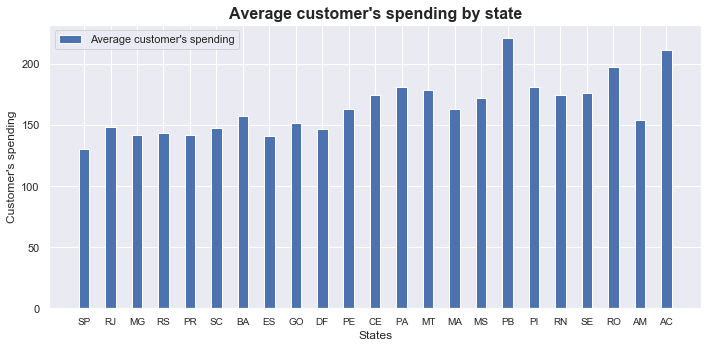

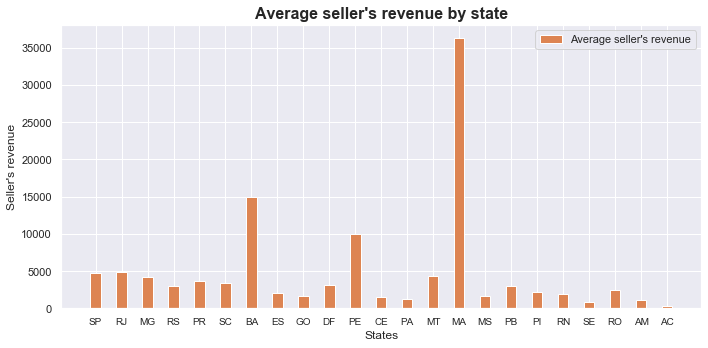

In [658]:
# Plot average customer's spending by state
fig = plt.gcf()
fig.set_size_inches(10,5)
n_groups_1 = len(customer_avg_spending.keys())
index_1 = np.arange(n_groups_1)

bar = plt.bar(index_1, customer_avg_spending, bar_width, label = 'Average customer\'s spending')
plt.title('Average customer\'s spending by state', fontweight="bold", size=16)
plt.xlabel('States')
plt.ylabel('Customer\'s spending')
plt.xticks(index_1, customer_avg_spending.keys())
plt.xticks(fontsize=10)
plt.legend()
plt.tight_layout()
plt.show();

# Plot average seller's revenue by state
fig = plt.gcf()
fig.set_size_inches(10,5)
n_groups_2 = len(seller_avg_revenue.keys())
index_2 = np.arange(n_groups_2)
bar_width = 0.4

bar = plt.bar(index_2, seller_avg_revenue, bar_width, label = 'Average seller\'s revenue', color = 'C1')
plt.title('Average seller\'s revenue by state', fontweight="bold", size=16)
plt.xlabel('States')
plt.ylabel('Seller\'s revenue')
plt.xticks(index_2, seller_avg_revenue.keys())
plt.xticks(fontsize=10)
plt.legend()
plt.tight_layout()
plt.show();

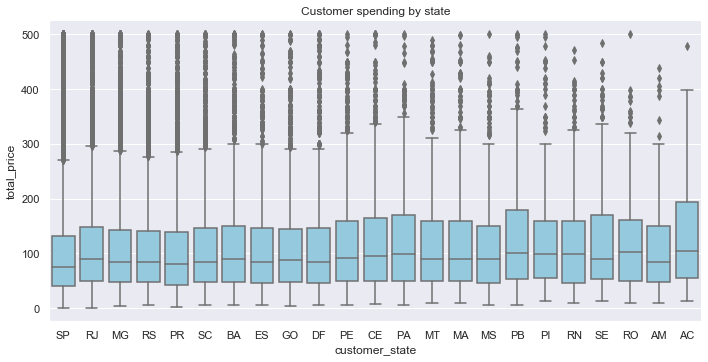

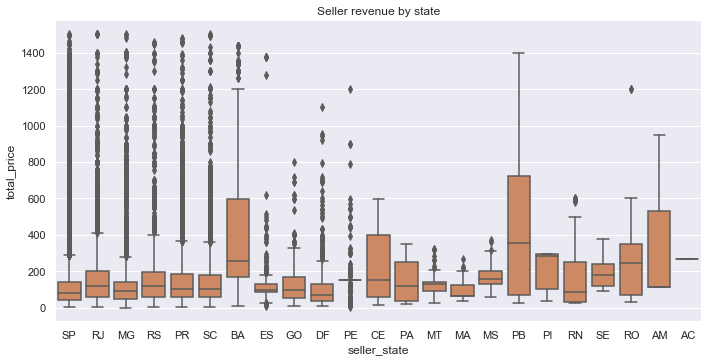

In [659]:
# Catplot for the range of customer spending and sellers revenue by state
sns.catplot(x = 'customer_state', y = 'total_price', kind = 'box',
            data = df[df['total_price'] < 500], height = 5, aspect = 2, order = customer_avg_spending.index, color = 'skyblue')
plt.title('Customer spending by state')
plt.show();

sns.catplot(x = 'seller_state', y = 'total_price', kind = 'box',
            data = df[df['total_price'] < 1500], height = 5, aspect = 2, order = seller_avg_revenue.index, color = 'C1')
plt.title('Seller revenue by state')
plt.show();

### iv. Number of reviews by state

In [660]:
# get number of reviews by state
reiew_scores = (df.reset_index()).groupby(['customer_state', 'review_score'])['order_id'].count().to_frame()
reiew_scores = reiew_scores.rename(columns = {'order_id':'review_count'})

# total review count by state
reiew_scores['total_review_count'] = reiew_scores.groupby(level = 'customer_state').transform('sum')
reiew_scores = reiew_scores.sort_values(['total_review_count', 'review_count'], ascending=[False, True])

# Unstack dataframe
reiew_scores = reiew_scores.unstack(1).reindex(pd.unique(reiew_scores.index\
                        .get_level_values(0))).sort_index(axis=1,level=1).drop('total_review_count', axis = 1)

//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


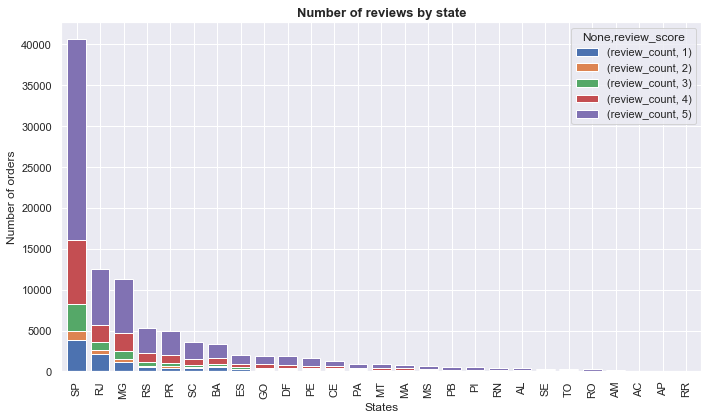

In [661]:
reiew_scores.plot(kind = 'bar', width = 0.8, stacked = True, figsize=(10,6))
plt.title('Number of reviews by state', fontweight="bold", size=13)
plt.xlabel('States')
plt.ylabel('Number of orders')
plt.tight_layout()
plt.show();

### v. Review score distribution by customer and seller state

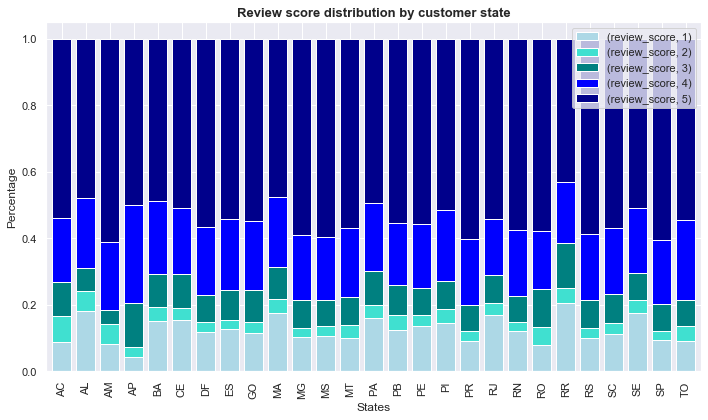

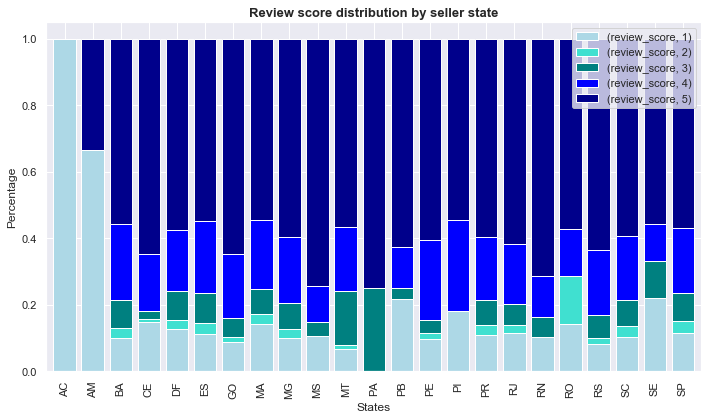

In [662]:
# Review distribution by customer and seller state
customer_score = df.groupby(['customer_state'])['review_score'].value_counts(normalize = True).to_frame().unstack()

color = ['lightblue', 'turquoise', 'teal','blue','darkblue']
customer_score.plot(kind = 'bar', width = 0.8, stacked = True, figsize=(10,6), color = color)
plt.title('Review score distribution by customer state', fontweight="bold", size=13)
plt.xlabel('States')
plt.ylabel('Percentage')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show();

seller_score = df.groupby(['seller_state'])['review_score'].value_counts(normalize = True).to_frame().unstack()

color = ['lightblue', 'turquoise', 'teal','blue','darkblue']
seller_score.plot(kind = 'bar', width = 0.8, stacked = True, figsize=(10,6), color = color)
plt.title('Review score distribution by seller state', fontweight="bold", size=13)
plt.xlabel('States')
plt.ylabel('Percentage')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show();

### c. Customers

### i. Number of returning customers

In [663]:
# Number of returning customers
customer_purchases = df['customer_unique_id'].value_counts().to_frame()\
                    .rename(columns = {'customer_unique_id': 'number_of_orders'})
returning_customer = customer_purchases[customer_purchases['number_of_orders'] > 1]

# Get percentage of customer purchases
customer_pur_pct = customer_purchases['number_of_orders'].value_counts(normalize = True)
print('Within', df['customer_unique_id'].nunique(), 'of unique customers, there is', len(returning_customer), 'of returning customers.')
print('There is', round(customer_pur_pct[:1].get(key = 1)*100, 2),'% of customers purchased once only.')

Within 93598 of unique customers, there is 2827 of returning customers.
There is 96.98 % of customers purchased once only.


The chart below shows the percentage distribution within 3.02 % of retruning customers:


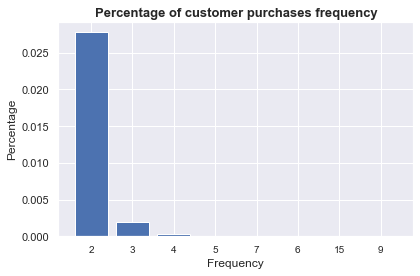

In [664]:
print('The chart below shows the percentage distribution within',\
          round(100 - (customer_pur_pct[:1].get(key = 1)*100), 2), '% of retruning customers:')

# Plot customer purchases frequency
customer_return_rate = customer_pur_pct[1::]
fig = plt.gcf()
fig.set_size_inches(6,4)
n_groups = len(customer_return_rate.keys())
index = np.arange(n_groups)

plt.bar(index, customer_return_rate)
plt.title('Percentage of customer purchases frequency', fontweight="bold", size=13)
plt.xlabel('Frequency')
plt.ylabel('Percentage')
plt.xticks(index, customer_return_rate.keys())
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show();

### ii. Number of returning customers by states

In [665]:
# Returning customers by states

# Get number of orders per customers
number_of_orders = df['customer_unique_id'].value_counts().to_frame()\
                    .rename(columns = {'customer_unique_id': 'number_of_orders'})\
                    .reset_index().rename(columns = {'index': 'customer_unique_id'})

# Get number of orders according to states
unique_customer = df.merge(number_of_orders, on = 'customer_unique_id')

# Get number of returning unique customers by states
unique_customer_states = unique_customer[unique_customer['number_of_orders'] > 1]
unique_customer_states = unique_customer_states.groupby(['customer_state', 'number_of_orders'])['customer_unique_id'].count().to_frame()
unique_customer_states = unique_customer_states.rename(columns = {'customer_unique_id':'Number of orders'})

# Sort states according to the number of orders in descending order
unique_customer_states['total_returning_orders'] = unique_customer_states.groupby(level = 'customer_state').transform('sum')
unique_customer_states = unique_customer_states.sort_values(['total_returning_orders', 'number_of_orders'], ascending=[False, True])

# Unstack dataframe
unique_customer_states = unique_customer_states.unstack(1).reindex(pd.unique(unique_customer_states.index\
                        .get_level_values(0))).sort_index(axis=1,level=1).drop('total_returning_orders', axis = 1)

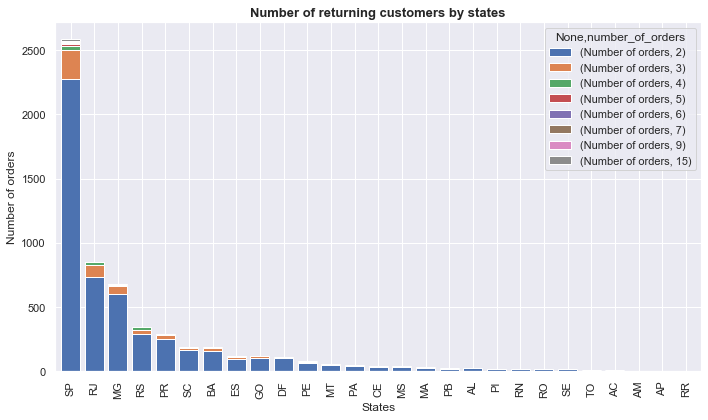

In [666]:
unique_customer_states.plot(kind = 'bar', width = 0.8, stacked = True, figsize=(10,6))
plt.title('Number of returning customers by states', fontweight="bold", size=13)
plt.xlabel('States')
plt.ylabel('Number of orders')
plt.tight_layout()
plt.show();

### d. Product categories

### i. Most sold product categories

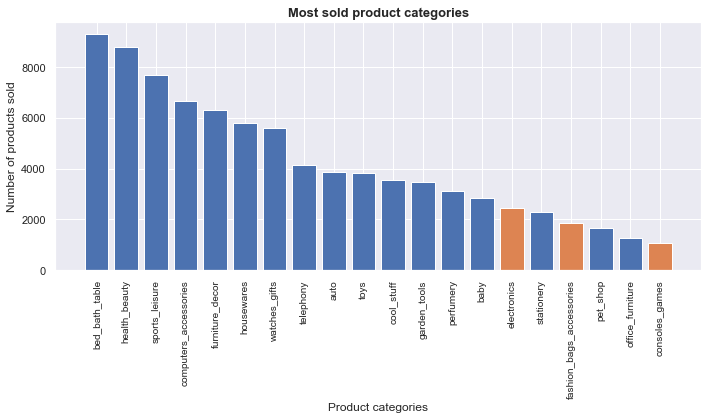

In [667]:
# Get the top 20 most sold product categories
product_cat_count = df['product_category'].value_counts().nlargest(20)

fig = plt.gcf()
fig.set_size_inches(10,6)
n_groups = len(product_cat_count.keys())
index = np.arange(n_groups)
color = ['C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C1', 'C0', 'C1', 'C0', 'C0', 'C1']

plt.bar(index, product_cat_count, color = color)
plt.title('Most sold product categories', fontweight="bold", size=13)
plt.xlabel('Product categories')
plt.ylabel('Number of products sold')
plt.xticks(index, product_cat_count.keys(), rotation = 90)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show();

### ii. Total value sold on each product categories

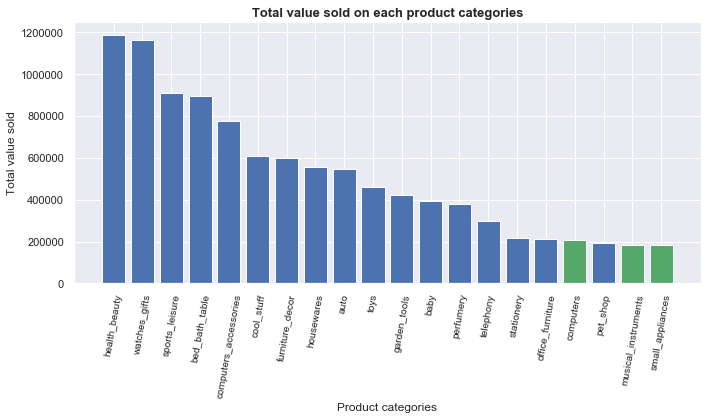

In [668]:
# Get the top 20 largest total value sold on each product categories
cat_value_df_top20 = df.groupby('product_category')['price'].sum().nlargest(20)

fig = plt.gcf()
fig.set_size_inches(10,6)
n_groups = len(cat_value_df_top20.keys())
index = np.arange(n_groups)
color = ['C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C2', 'C0', 'C2', 'C2']

plt.bar(index, cat_value_df_top20, color = color)
plt.title('Total value sold on each product categories', fontweight="bold", size=13)
plt.xlabel('Product categories')
plt.ylabel('Total value sold')
plt.xticks(index, cat_value_df_top20.keys(), rotation = 80)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show();

### iii. Price range of product categories

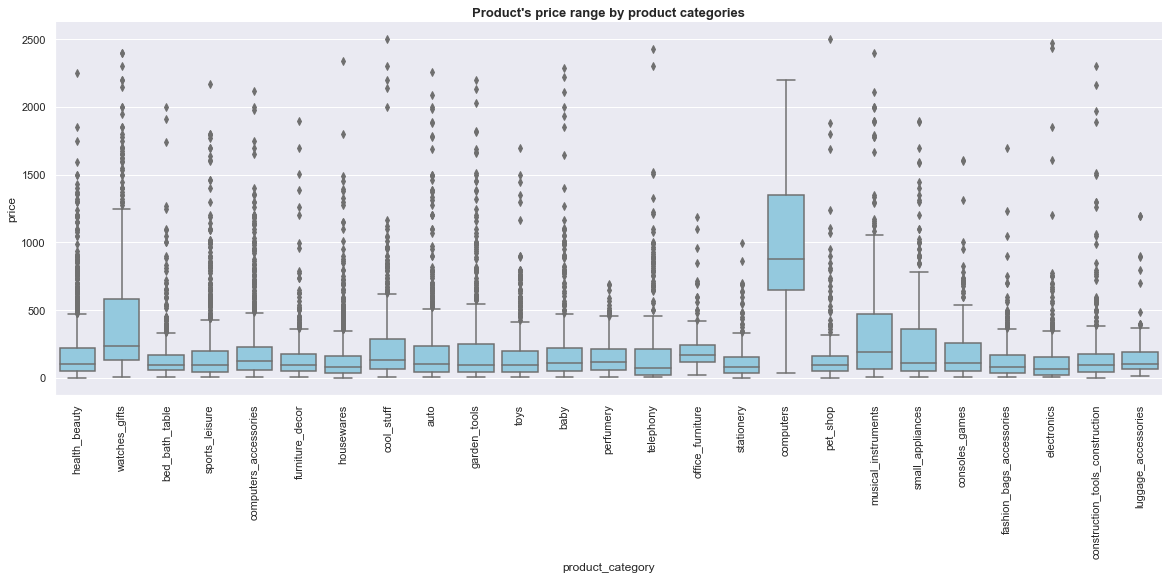

In [670]:
# Price range of product categories
pro_price_range = df.groupby(['product_category', 'price']).sum()
pro_price_range = pro_price_range[['total_price']].reset_index()
total_value = df.groupby('product_category')['total_price'].sum().nlargest(25).to_frame().reset_index()
total_value = total_value.rename(columns = {'total_price':'total_value'})
product_price = pro_price_range[pro_price_range.product_category.isin(total_value.product_category)]

sns.catplot(x = 'product_category', y = 'price', kind = 'box', order = total_value['product_category'].to_list(),
            data = product_price[product_price['price']<2500], height = 6, aspect = 2.8, color = 'skyblue')
plt.title('Product\'s price range by product categories', fontweight="bold", size=13)
plt.xticks(rotation = 90)
plt.show();

<div class="alert alert-success">

<p> The highlighted orange bar in the chart "Most sold product categories", are the categories that are most sold but not included in the top 20 valued product categories. This implied that although there is a large number of products sold under that particular categories, the value of the products sold is lower than the other products that are included in the above chart. Adversely, with the green bar in the chart "Total value sold on each product categories", are the categories that are not included in the top 20 most sold categories. This indicated that the value of the products under these categories have a higher value compared with other products categories which can generate higher value.  </p>


</div>


### e. Orders delivery

### i. Delivery time in days

In [671]:
# Turn order_purchase_timestamp and orders_approved_at columns into datetime format for further calculation
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# get delivery time in days
df['actual_delivery_time'] = (df['order_delivered_customer_date'] - df['order_approved_at'])\
                                        .dt.total_seconds() / 86400
df['estimated_delivery_time'] = (df['order_estimated_delivery_date'] - df['order_approved_at'])\
                                        .dt.total_seconds() / 86400

#get the differences between estimated delivery time and actual delivery time
df['actual_estimated_delivery_diff'] = df['estimated_delivery_time'] - df['actual_delivery_time']

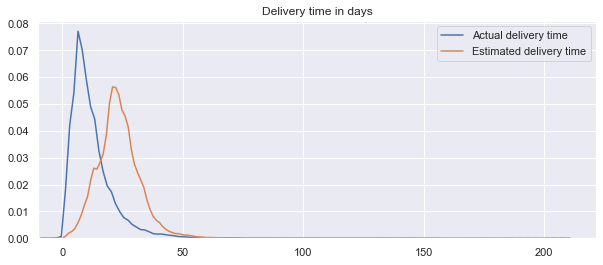

In [672]:
# Delivery estimated time and actual delivery time
plt.figure(figsize=(10,4))
plt.title("Delivery time in days")
ax1 = sns.kdeplot(df['actual_delivery_time'].dropna(), color = 'C0', label = 'Actual delivery time')
ax2 = sns.kdeplot(df['estimated_delivery_time'].dropna(), color = 'C1', label = 'Estimated delivery time')
plt.xlim(left = -10)
plt.show();

### ii. Percentage of order status

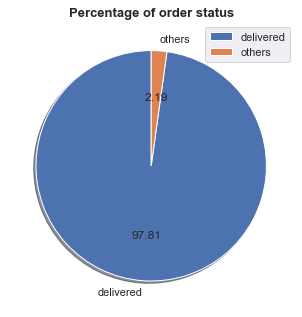

In [673]:
# Order status
grp_order_status = df.order_status.value_counts(normalize = True).to_frame().reset_index()

# group other order status into 'others'
grp_order_status = grp_order_status.append({'index' : 'others', 'order_status' : grp_order_status.order_status[1::].sum()}, ignore_index = True)
grp_order_status = grp_order_status.set_index('index')
grp_order_status = grp_order_status.loc[['delivered', 'others']].order_status

fig = plt.figure(figsize=(5,5))
ax = fig.add_axes((0,0,0.8,1))
labels = grp_order_status.keys()
sizes = np.array(grp_order_status.tolist())

def absolute_value(val):
    a = np.round(val*sizes.sum(), 2)
    return a

plt.pie(grp_order_status, labels=labels, autopct=absolute_value,
        shadow=True, startangle=90)

plt.title('Percentage of order status'\
          , fontweight="bold", size=13)
plt.legend()
plt.show();

### iii. Relationship between review score and order status

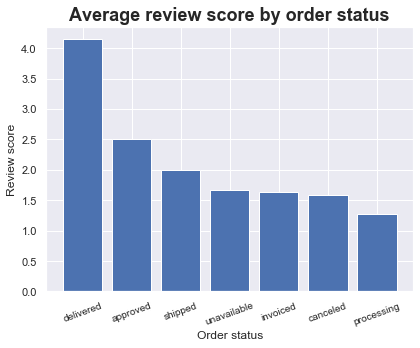

In [674]:
order_review = df.groupby('order_status')['review_score'].value_counts().rename('review_count').to_frame().reset_index()
order_review['total_review'] = order_review['review_score']*order_review['review_count']
avg_score = (order_review.groupby('order_status')['total_review'].sum()/\
            order_review.groupby('order_status')['review_count'].sum()).sort_values(ascending = False)

fig = plt.gcf()
fig.set_size_inches(6,5)
n_groups = len(avg_score.keys())
index = np.arange(n_groups)

plt.bar(index, avg_score)
plt.title('Average review score by order status', fontweight="bold", size=18)
plt.xlabel('Order status')
plt.ylabel('Review score')
plt.xticks(index, avg_score.keys())
plt.xticks(fontsize=10, rotation = 20)
plt.tight_layout()
plt.show();

### iv. relationship between delivery time and review score

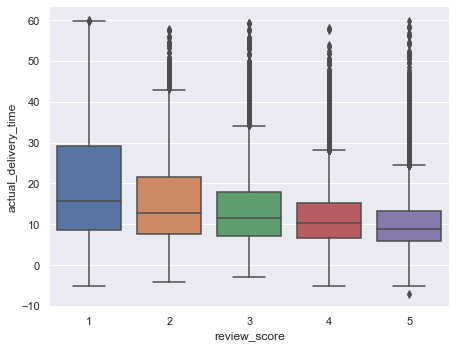

In [675]:
# How actual delivery time affect review score
sns.catplot(x = 'review_score', y = 'actual_delivery_time', kind = 'box',
            data = df[df.actual_delivery_time < 60], height = 5, aspect = 1.3)
plt.show();

### v. Impact on review score when actual delivery is longer than estimated delivery time

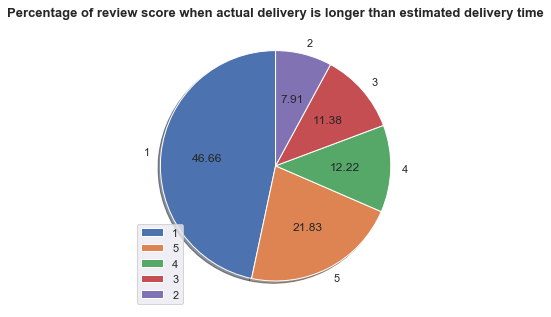

In [676]:
# percentage of review score when actual delivery is longer than estimated delivery time
reviews_on_delivery_diff = df[df['actual_estimated_delivery_diff'] < 0]\
                            .review_score.value_counts(normalize = True)

fig = plt.figure(figsize=(5,5))
ax = fig.add_axes((0,0,0.8,1))
labels = reviews_on_delivery_diff.keys()
sizes = np.array(reviews_on_delivery_diff.tolist())

def absolute_value(val):
    a = np.round(val*sizes.sum(), 2)
    return a

plt.pie(reviews_on_delivery_diff, labels=labels, autopct=absolute_value,
        shadow=True, startangle=90)

plt.title('Percentage of review score when actual delivery is longer than estimated delivery time'\
          , fontweight="bold", size=13)
plt.legend(loc = 'lower left')
plt.show();

### f. Sales

### i. Sales distribution in day

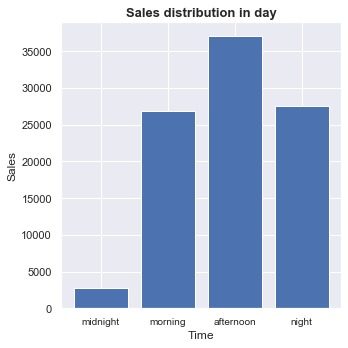

In [684]:
# Sales per hour
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
time_split = df['order_purchase_timestamp'].dt.time.astype(str).str.split(':')
hour = [x[:1] for x in time_split]
hour_df = pd.DataFrame(hour).rename(columns = {0:'hour'})
hour_df['hour'] = hour_df['hour'].astype(int)
hour_df['hour_group'] = pd.cut(hour_df.hour, [0,6,12,18,23], labels = ['midnight', 'morning', 'afternoon', 'night'])

# Categorize into 4 time zone in a day
cats = ['midnight', 'morning', 'afternoon', 'night']
hour_group = hour_df['hour_group'].value_counts().to_frame().reset_index()
hour_group = hour_group.set_index('index').reindex(cats)

fig = plt.gcf()
fig.set_size_inches(5,5)
n_groups = len(hour_group['hour_group'].keys())
index = np.arange(n_groups)

plt.bar(index, hour_group['hour_group'])
plt.title('Sales distribution in day', fontweight="bold", size=13)
plt.xlabel('Time')
plt.ylabel('Sales')
plt.xticks(index, hour_group['hour_group'].keys())
plt.xticks(fontsize=10, rotation = 0)
plt.tight_layout()
plt.show();

### ii. Sales per date

In [679]:
# Sales per date
# Turn datetime column into date format and get the total price per date and total freight value per date
value_per_date = df.groupby(df['order_purchase_timestamp'].dt.date)['price'].sum()
freight_per_date = df.groupby(df['order_purchase_timestamp'].dt.date)['freight_value'].sum()

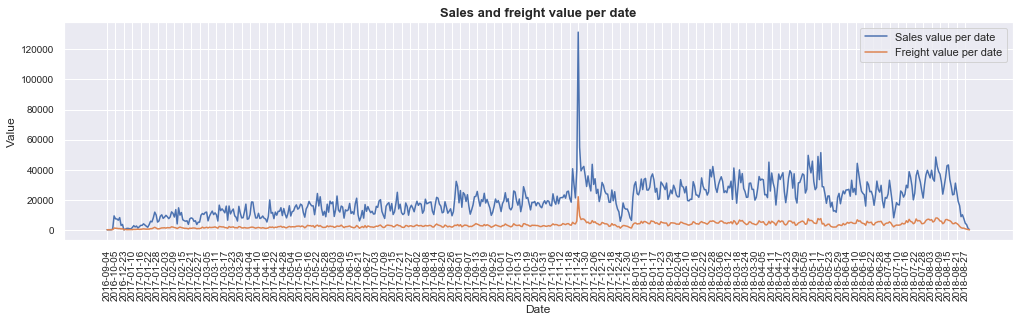

In [681]:
# Sales and freight value per date
# Reset datetime into str format
value_per_date_list = value_per_date.reset_index()
value_per_date_list['datetime'] = value_per_date_list['order_purchase_timestamp'].astype(str)
date_list = [x for x in value_per_date_list['datetime']]

fig = plt.gcf()
fig.set_size_inches(17,4)
n_groups_1 = len(value_per_date)
n_groups_2 = len(freight_per_date)
index_1 = np.arange(n_groups_1)
index_2 = np.arange(n_groups_2)
xticks_index = np.arange(len(date_list))

plt.plot(index_1, value_per_date, label = 'Sales value per date', color = 'C0')
plt.plot(index_2, freight_per_date, label = 'Freight value per date', color = 'C1')

plt.title('Sales and freight value per date', fontweight="bold", size=13)
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(np.arange(min(xticks_index), max(xticks_index)+1, 6), date_list[::6], fontsize = 10, rotation = 90)
plt.yticks(fontsize=10)
plt.legend()
plt.show();

### iii. Sales per month

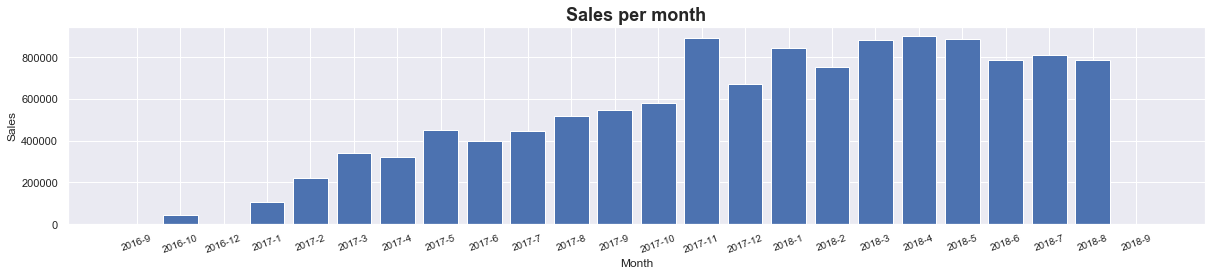

In [682]:
# Sales per month
sales_df = df[['order_purchase_timestamp', 'price']].copy()
sales_df['year'] = (sales_df['order_purchase_timestamp'].dt.year).astype('str')
sales_df['month'] = (sales_df['order_purchase_timestamp'].dt.month).astype('str')
sales_df['date'] = sales_df['year'] + '-' + sales_df['month']
sales_per_month = sales_df.groupby(sales_df['date'])['price'].sum()
sales_per_month = sales_per_month.reindex(['2016-9', '2016-10', '2016-12', '2017-1', '2017-2', '2017-3', '2017-4', '2017-5', '2017-6', '2017-7',
                       '2017-8', '2017-9', '2017-10', '2017-11', '2017-12', '2018-1', '2018-2', '2018-3', '2018-4', '2018-5', 
                        '2018-6', '2018-7', '2018-8', '2018-9'])

fig = plt.gcf()
fig.set_size_inches(17,4)
n_groups = len(sales_per_month.keys())
index = np.arange(n_groups)

plt.bar(index, sales_per_month)
plt.title('Sales per month', fontweight="bold", size=18)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(index, sales_per_month.keys())
plt.xticks(fontsize=10, rotation = 20)
plt.tight_layout()
plt.show();

## 5. Data preparation and feature engineering

### a. Create dependent variable

As this project aimed to predict customer satisfaction, review score is regarded as dependent variable.

In [52]:
df = df.set_index('order_id')

In [53]:
def review_score(df):
    return df['review_score'].to_frame().reset_index()

In [54]:
review_score = review_score(df)
review_score.head()

,order_id,review_score
0,00e7ee1b050b8499577073aeb2a297a1,4
1,a4866dfc455353f48014a2b9a86608a2,4
2,03afb3c10af52ddfa3c33b9881bf43f8,4
3,3c75044db750a89606612ed286713eb8,3
4,edc9338008f2e9017f842a8bcad3af94,5


### b. Data cleaning
After exploratory data analysis, the variables removed below do not have much relationship between review score, therefore, they are removed for further analysis.

In [55]:
df.drop(['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_name_lenght', 
            'product_description_lenght', 'product_photos_qty'], axis = 1, inplace = True)

In [56]:
# df_copy is created for better utilization
df_copy = df.copy().reset_index()

In [57]:
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])

### c. Feature engineering

In order to get prediction on customer satisfaction, it is essential to create some useful measuarable quantities for fair comparison. 

Based on the data that are available, it is sensible to generate features under four groups:
1. Customer features
2. Product features
3. Sellers features
4. Courier features

In [58]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,order_status,order_purchase_timestamp,order_approved_at,...,review_score,product_category,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,actual_delivery_time,estimated_delivery_time,actual_estimated_delivery_diff
order_id,,,,,,,,,,,,,,,,,,,,,
00e7ee1b050b8499577073aeb2a297a1,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,...,4,office_furniture,8577,itaquaquecetuba,SP,-23.482623,-46.37449,8.800961,19.359583,10.558623
a4866dfc455353f48014a2b9a86608a2,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,barreiras,BA,-12.147031,-44.996092,delivered,2018-01-11 16:47:03,2018-01-11 16:55:38,...,4,office_furniture,8577,itaquaquecetuba,SP,-23.482623,-46.37449,33.843241,48.294699,14.451458
03afb3c10af52ddfa3c33b9881bf43f8,44e25679aa4d5d2ef5103f6b0174a586,613259d64ba972e49dc25b019b7918c3,6414,barueri,SP,-23.495901,-46.874687,delivered,2017-12-07 16:41:50,2017-12-07 16:51:57,...,4,office_furniture,8577,itaquaquecetuba,SP,-23.482623,-46.37449,11.054525,32.297257,21.242731
3c75044db750a89606612ed286713eb8,ac318397fb90e64c9a724a3fc61ef587,aaad33c5051196b5e73c7d65b9072e1d,37137,alfenas,MG,-21.407289,-45.940358,delivered,2018-03-13 20:11:20,2018-03-13 20:49:24,...,3,office_furniture,8577,itaquaquecetuba,SP,-23.482623,-46.37449,20.244988,36.132361,15.887373
edc9338008f2e9017f842a8bcad3af94,cf4dc8d4be7642c7c05a73188a3d8c1c,35c0fa6f2e6bbb3576e725d22e1066b8,23585,rio de janeiro,RJ,-22.928011,-43.642049,delivered,2017-04-28 16:55:22,2017-04-28 17:10:12,...,5,office_furniture,8577,itaquaquecetuba,SP,-23.482623,-46.37449,17.954572,33.284583,15.330012


### 1. Customer features

### i. Customer state

Based on the exploratory data analysis done above, it is shown that customers location will impact on customer satisfaction due to demographic differences. Therefore, customer location will be included in the metrics to capture demographic location under each order. 

In [59]:
def customer_state(df):
    df_copy = df.reset_index()
    customer_state = df_copy.groupby('order_id')['customer_state'].value_counts().unstack().reset_index()
    customer_state.fillna(0, inplace = True)
    return customer_state

In [60]:
customer_state = customer_state(df)
customer_state.head()

customer_state,order_id,AC,AL,AM,AP,BA,CE,DF,ES,GO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,00010242fe8c5a6d1ba2dd792cb16214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00018f77f2f0320c557190d7a144bdd3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,000229ec398224ef6ca0657da4fc703e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00024acbcdf0a6daa1e931b038114c75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### ii. Number of orders
The more customer purchase, the higher possibility that customers will have higher satisfaction.

In [61]:
# Number of orders

def no_of_orders(df):
    no_of_orders = df['customer_unique_id'].value_counts().rename('no_of_orders').to_frame().reset_index()\
                    .rename(columns={'index':'customer_unique_id'})
    no_of_orders = (df.reset_index()).merge(no_of_orders, on ='customer_unique_id').reset_index()
    no_of_orders = no_of_orders[['order_id','no_of_orders']]
    return no_of_orders

In [62]:
no_of_orders = no_of_orders(df)
no_of_orders.head()

,order_id,no_of_orders
0,00e7ee1b050b8499577073aeb2a297a1,1
1,a4866dfc455353f48014a2b9a86608a2,1
2,03afb3c10af52ddfa3c33b9881bf43f8,1
3,3c75044db750a89606612ed286713eb8,1
4,edc9338008f2e9017f842a8bcad3af94,1


### iii. Average money spent per order

The more money spent per order may have a higher probability that the customer may have higher expectation on product and service.

In [63]:
def avg_money_spent_per_order(df):
    money_spent = df[['customer_unique_id', 'order_item_id', 'total_price', 'freight_value']].reset_index()
    money_spent = money_spent.merge(no_of_orders, on = 'order_id')
    money_spent['total_freight_value'] = money_spent['order_item_id']*money_spent['freight_value']
    total_spending = money_spent.groupby('customer_unique_id')['total_price', 'total_freight_value'].sum()
    total_spending['total_spending'] = total_spending['total_price']+total_spending['total_freight_value']
    money_spent = money_spent.merge(total_spending.reset_index(), on = 'customer_unique_id')
    money_spent['avg_money_spent'] = money_spent['total_spending']/money_spent['no_of_orders']
    money_spent = money_spent[['order_id','avg_money_spent']]
    return money_spent

In [64]:
avg_money_spent_per_order = avg_money_spent_per_order(df)
avg_money_spent_per_order.head()

,order_id,avg_money_spent
0,00e7ee1b050b8499577073aeb2a297a1,146.87
1,a4866dfc455353f48014a2b9a86608a2,340.50
2,03afb3c10af52ddfa3c33b9881bf43f8,131.50
3,3c75044db750a89606612ed286713eb8,174.07
4,edc9338008f2e9017f842a8bcad3af94,140.03


### 2. Product features

### i. Average product rating
Each customer perceive product differently, which will result to a variation of review score under the same product. Therefore, average product rating will be calculated in order to understand how likely the product is perceived by all customers who purchase the same product.

In [65]:
product_rating = df[['product_id','review_score']]
product_rating = product_rating.groupby('product_id')['review_score'].value_counts().rename('review_count').to_frame().reset_index()
product_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46912 entries, 0 to 46911
Data columns (total 3 columns):
product_id      46912 non-null object
review_score    46912 non-null int64
review_count    46912 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [66]:
# Average review score for that particular product

def avg_product_rating(df):
    product_rating = df[['product_id','review_score']]
    
    # get total review score by product
    product_rating = product_rating.groupby('product_id')['review_score'].value_counts().rename('review_count').to_frame().reset_index()
    product_rating['total_review'] = product_rating['review_score']*product_rating['review_count']
    
    # get the average product rating
    product_rating = (product_rating.groupby('product_id')['total_review'].sum()/\
                product_rating.groupby('product_id')['review_count'].sum()).rename('avg_product_rating').to_frame().reset_index()
    avg_product_rating = df_copy.merge(product_rating, on = 'product_id')
    avg_product_rating = avg_product_rating[['order_id', 'avg_product_rating']]
    
    # get product rating catefory in the range 1-5
    avg_product_rating['avg_product_rating_cat'] = pd.cut(avg_product_rating.avg_product_rating, [0,1,2,3,4,5],\
                                                        labels = [1,2,3,4,5])
    avg_product_rating = avg_product_rating[['order_id', 'avg_product_rating', 'avg_product_rating_cat']]
    return avg_product_rating

In [67]:
avg_product_rating = avg_product_rating(df)
avg_product_rating.head()

,order_id,avg_product_rating,avg_product_rating_cat
0,00e7ee1b050b8499577073aeb2a297a1,3.384615,4
1,a4866dfc455353f48014a2b9a86608a2,3.384615,4
2,03afb3c10af52ddfa3c33b9881bf43f8,3.384615,4
3,3c75044db750a89606612ed286713eb8,3.384615,4
4,edc9338008f2e9017f842a8bcad3af94,3.384615,4


### ii. Average product quality
Although product quality may perceived differently by customers, it is an essential measurement on customers satisfaction. Therefore, average product quality is calculated to measure by comparing the products within same product category. When the average product rating is higher than the average rating of that particular product category, it will be regarded as 1, 0 otherwise. It is expected that higher average product quality will lead to higher customer satisfaction.

In [68]:
# Average review socre for each product category

def product_quality(df):
    product_cat = df_copy[['order_id', 'product_category', 'review_score']].copy()
    product_quality = product_cat.merge(avg_product_rating, on = 'order_id')
    avg_quality = product_quality.groupby('product_category')['review_score'].mean().rename('avg_quality')
    product_quality = product_quality.reset_index().merge(avg_quality, on = 'product_category').set_index('order_id')
    product_quality['product_quality'] = np.where((product_quality['avg_product_rating'] > product_quality['avg_quality']), 1,0)
    product_quality = product_quality['product_quality'].reset_index()
    return product_quality

In [69]:
product_quality = product_quality(df)
product_quality.head()

,order_id,product_quality
0,00e7ee1b050b8499577073aeb2a297a1,0
1,a4866dfc455353f48014a2b9a86608a2,0
2,03afb3c10af52ddfa3c33b9881bf43f8,0
3,3c75044db750a89606612ed286713eb8,0
4,edc9338008f2e9017f842a8bcad3af94,0


### iii. Product price
The varaition of product price will differs customer satisfaction. Also, when customers purchase a product with a higher price in a particular quality, they may have a higher requirement and standard on satisfaction. In contrast, when customer purchase products that are cheaper than average under that product category, they may tend to rate a higher score. Therefore, lower price than average under that particular category will regarded as 1, 0 otherwise. 

In [70]:
# Average price for each product category

def product_price(df):
    product_price = df[['product_category', 'price']].copy()
    product_price = product_price.reset_index()
    avg_product_price = df.groupby(['product_category'])['price'].mean().to_frame()\
                .rename(columns = {'price':'avg_product_price'}).reset_index()
    product_price = product_price.merge(avg_product_price, on = 'product_category').set_index('order_id')
    product_price['product_price'] = np.where((product_price['avg_product_price'] > product_price['price']), 1,0)
    product_price = product_price[['price', 'avg_product_price', 'product_price']].reset_index()
    return product_price

In [71]:
product_price = product_price(df)
product_price.head()

,order_id,price,avg_product_price,product_price
0,00e7ee1b050b8499577073aeb2a297a1,124.99,168.483862,1
1,a4866dfc455353f48014a2b9a86608a2,126.99,168.483862,1
2,03afb3c10af52ddfa3c33b9881bf43f8,112.99,168.483862,1
3,3c75044db750a89606612ed286713eb8,116.99,168.483862,1
4,edc9338008f2e9017f842a8bcad3af94,124.99,168.483862,1


### iv. Number of product sold
Customers usually will purchase products that have a higher sales, by getting the total number of that particular item sold enable customer to have a better insight of how the quality of the product it. 

In [72]:
def product_sold(df):
    product_sold = df_copy.groupby('product_id')['order_id'].count().rename('product_sold')
    product_sold = df_copy.merge(product_sold, on = 'product_id')
    product_sold = product_sold[['order_id', 'product_sold']]
    return product_sold

In [73]:
product_sold = product_sold(df)
product_sold.head()

,order_id,product_sold
0,00e7ee1b050b8499577073aeb2a297a1,39
1,a4866dfc455353f48014a2b9a86608a2,39
2,03afb3c10af52ddfa3c33b9881bf43f8,39
3,3c75044db750a89606612ed286713eb8,39
4,edc9338008f2e9017f842a8bcad3af94,39


### 3. Sellers features

### i. Sellers location
Based on the exploratory data analysis, some of the products sold in that particular seller state tend to have a higher ratings. Therefore, it may be possible that particular state enable to sell some products that are have higher quality or better services which increase the ratings.

In [74]:
def seller_state(df):
    df_copy = df.reset_index()
    seller_state = df_copy.groupby('order_id')['seller_state'].value_counts().unstack().reset_index()
    seller_state.fillna(0, inplace = True)
    return seller_state

In [75]:
seller_state = seller_state(df)
seller_state.head()

seller_state,order_id,AC,AM,BA,CE,DF,ES,GO,MA,MG,...,PE,PI,PR,RJ,RN,RO,RS,SC,SE,SP
0,00010242fe8c5a6d1ba2dd792cb16214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00018f77f2f0320c557190d7a144bdd3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,000229ec398224ef6ca0657da4fc703e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00024acbcdf0a6daa1e931b038114c75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ii. Total number of items sold
Total number of items sold by sellers enable us to understand how likely the quality of the products sold by that seller is. It is expected that more products that are sold by that particular seller, the higher reputation that seller is gained from customers, which will result to higher customer satisfaction. 

In [687]:
def product_sold_by_seller(df):
    product_sold_by_seller = df_copy.groupby('seller_id')['order_id'].count().rename('product_sold_by_seller')
    product_sold_by_seller = df_copy.merge(product_sold_by_seller, on = 'seller_id')
    product_sold_by_seller = product_sold_by_seller[['order_id','product_sold_by_seller']]
    return product_sold_by_seller

In [688]:
product_sold_by_seller = product_sold_by_seller(df)
product_sold_by_seller.head()

,order_id,product_sold_by_seller
0,00e7ee1b050b8499577073aeb2a297a1,974
1,a4866dfc455353f48014a2b9a86608a2,974
2,03afb3c10af52ddfa3c33b9881bf43f8,974
3,3c75044db750a89606612ed286713eb8,974
4,edc9338008f2e9017f842a8bcad3af94,974


### iii. Seller's rating

Total number of items sold by sellers enable us to understand how likely the quality of the products sold by that seller is. It is expected that more products that are sold by that particular seller, the higher reputation that seller is gained from customers, which will result to higher customer satisfaction.

In [76]:
def review_count(df):
    avg_review = df_copy[['seller_id', 'product_id', 'product_category', 'review_score']].copy()

    # Get the review count of each product category under each seller
    review_count = avg_review.groupby(['seller_id','product_id', 'product_category'])['review_score'].value_counts()\
            .rename('review_count').to_frame().reset_index()

    # Get the total reviews of each product category under each seller
    review_count['total_reviews'] = review_count['review_score']*review_count['review_count']
    return review_count

In [77]:
review_count = review_count(df)

In [78]:
def number_of_product(df):

    # Get the average review score per product of each category that particular seller sold
    avg_review_per_product = (review_count.groupby(['seller_id', 'product_id', 'product_category'])['total_reviews'].sum()/\
                review_count.groupby(['seller_id', 'product_id', 'product_category'])['review_count'].sum())\
                    .rename('avg_review_per_product').to_frame().reset_index()

    # Sum up all the review score under that particular category
    avg_review_per_product = avg_review_per_product.groupby(['seller_id', 'product_category'])['avg_review_per_product']\
                    .sum().to_frame()
    
    # Get the number of products of each product category that particular seller sold
    number_of_product = review_count.groupby(['seller_id','product_id'])['product_category'].value_counts()\
            .rename('number_of_product').to_frame().reset_index()

    # Get the total number of product category that particular seller sold
    number_of_product = number_of_product.groupby('seller_id')['product_category'].value_counts()\
            .rename('category_count').to_frame().reset_index()
    
    return number_of_product

In [79]:
number_of_product = number_of_product(df)

In [80]:
def avg_rating(df):  
    avg_review_per_product = (review_count.groupby(['seller_id', 'product_id', 'product_category'])['total_reviews'].sum()/\
                review_count.groupby(['seller_id', 'product_id', 'product_category'])['review_count'].sum())\
                    .rename('avg_review_per_product').to_frame().reset_index()

    # Sum up all the review score under that particular category
    avg_review_per_product = avg_review_per_product.groupby(['seller_id', 'product_category'])['avg_review_per_product']\
                    .sum().to_frame()

    # Merge two dataframes into one
    avg_rating = avg_review_per_product.merge(number_of_product, on = ['seller_id', 'product_category'])

    # Get the average seller rating by summing up the average rating of that product category and 
    # divided the sum of product category count
    avg_rating['avg_rating'] = avg_rating.avg_review_per_product/avg_rating.category_count
    return avg_rating

In [81]:
avg_rating = avg_rating(df)

In [82]:
def avg_seller_rating(df):
    avg_seller_rating = (avg_rating.groupby('seller_id')['avg_rating'].sum()/avg_rating.groupby('seller_id')\
                             ['product_category'].count()).rename('avg_seller_rating').to_frame().reset_index()

    avg_seller_rating = df_copy.merge(avg_seller_rating, on = 'seller_id')
    avg_seller_rating = avg_seller_rating[['order_id','avg_seller_rating']]
    avg_seller_rating['avg_seller_rating_cat'] = pd.cut(avg_seller_rating.avg_seller_rating, [0,1,2,3,4,5],\
                                                        labels = [1,2,3,4,5])
    avg_seller_rating = avg_seller_rating[['order_id', 'avg_seller_rating_cat']]
    return avg_seller_rating

In [83]:
avg_seller_rating = avg_seller_rating(df)
avg_seller_rating.head()

,order_id,avg_seller_rating_cat
0,00e7ee1b050b8499577073aeb2a297a1,4
1,a4866dfc455353f48014a2b9a86608a2,4
2,03afb3c10af52ddfa3c33b9881bf43f8,4
3,3c75044db750a89606612ed286713eb8,4
4,edc9338008f2e9017f842a8bcad3af94,4


### iv. Better seller
Better seller is a percentage scale to understand how likely seller is a better seller. As mentioned above, since some of the quality of the products sold by that particular seller might not be the same. Therefore, seller will first get several review scores based on the number of product categories that he/she has sold. It will than compare with the average rating of that product category. Seller rating dummies will be created if seller has a higher rating compared with the average rating of that product category, it will be rated as 1, 0 otherwise. And the final better seller rating will be the seller rating dummies multiply by the weighted average of the number of product sold by seller under that particular category. The better the seller is when the score is closer to 1.

In [86]:
# How likely he or she is a better seller

avg_review_per_product = (review_count.groupby(['seller_id', 'product_id', 'product_category'])['total_reviews'].sum()/\
                review_count.groupby(['seller_id', 'product_id', 'product_category'])['review_count'].sum())\
                    .rename('avg_review_per_product').to_frame().reset_index()

# Sum up all the review score under that particular category
avg_review_per_product = avg_review_per_product.groupby(['seller_id', 'product_category'])['avg_review_per_product']\
                    .sum().to_frame()

# Merge two dataframes into one
avg_rating = avg_review_per_product.merge(number_of_product, on = ['seller_id', 'product_category'])

# Get the average seller rating by summing up the average rating of that product category and 
# divided the sum of product category count
avg_rating['avg_rating'] = avg_rating.avg_review_per_product/avg_rating.category_count
    
total_num_product = number_of_product.groupby(['seller_id'])['category_count'].sum().rename('total_num_product')\
                    .to_frame().reset_index()
number_of_product = number_of_product.merge(total_num_product, on = 'seller_id')
number_of_product['product_pct'] = number_of_product['category_count']/number_of_product['total_num_product']

avg_product_cat_review_score = df[['product_category', 'review_score']]
avg_product_cat_review_score = avg_product_cat_review_score.groupby('product_category')['review_score'].mean()\
                        .rename('avg_review_score').to_frame()

# avg_rating = avg_rating(df)[['seller_id', 'product_category', 'avg_rating']]
seller_rating_rate = avg_rating.merge(avg_product_cat_review_score, on = 'product_category')
seller_rating_rate['better_seller_dummy'] = np.where((seller_rating_rate['avg_rating'] > \
                                                        seller_rating_rate['avg_review_score']),1,0)
seller_rating_rate = seller_rating_rate.merge(number_of_product, on = ['seller_id', 'product_category'])
seller_rating_rate['better_seller'] = seller_rating_rate['better_seller_dummy'] * seller_rating_rate['product_pct']
better_seller = seller_rating_rate.groupby('seller_id')['better_seller'].sum().to_frame()
better_seller = df_copy.merge(better_seller, on = 'seller_id')
better_seller = better_seller[['order_id', 'better_seller']]

In [87]:
better_seller.head()

,order_id,better_seller
0,00e7ee1b050b8499577073aeb2a297a1,0.0
1,a4866dfc455353f48014a2b9a86608a2,0.0
2,03afb3c10af52ddfa3c33b9881bf43f8,0.0
3,3c75044db750a89606612ed286713eb8,0.0
4,edc9338008f2e9017f842a8bcad3af94,0.0


In [88]:
better_seller['better_seller'].nunique()

291

### 4. Courier feature

### i. Freight rate
Average freight value will be included in order to estimate how much will freight value cost for purchasing that particular product. It is expected that the higher the freight value will reduce customer satisfaction.

In [89]:
def freight_value(df):
    freight_value = df['freight_value'].rename('avg_freight_value').to_frame().reset_index()
    return freight_value

In [90]:
freight_value = freight_value(df)
freight_value.head()

,order_id,avg_freight_value
0,00e7ee1b050b8499577073aeb2a297a1,21.88
1,a4866dfc455353f48014a2b9a86608a2,43.26
2,03afb3c10af52ddfa3c33b9881bf43f8,18.51
3,3c75044db750a89606612ed286713eb8,57.08
4,edc9338008f2e9017f842a8bcad3af94,15.04


### ii. Order status
Based on the above exploratory data analysis, it is shown that order status will vary review score. 

In [91]:
def order_status(df):
    df_copy = df.reindex()
    order_status = df_copy.groupby('order_id')['order_status'].value_counts().unstack().reset_index()
    order_status.fillna(0, inplace = True)
    return order_status

In [92]:
order_status = order_status(df)
order_status.head()

order_status,order_id,approved,canceled,delivered,invoiced,processing,shipped,unavailable
0,00010242fe8c5a6d1ba2dd792cb16214,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,00018f77f2f0320c557190d7a144bdd3,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,000229ec398224ef6ca0657da4fc703e,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00024acbcdf0a6daa1e931b038114c75,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### iii. Delivery delay
When actual delivery is later than the estimated delivery, it will be regarded as 0, whereas when actual delivery is earlier than estimated delivery, it will be regarded as 1.

In [93]:
def delivery_delay(df):
    delivery_delay = df['actual_estimated_delivery_diff'].to_frame()
    delivery_delay['delivery_delay'] = np.where((df['actual_estimated_delivery_diff'] > 0), 1, 0)
    delivery_delay = delivery_delay['delivery_delay'].to_frame().reset_index()
    return delivery_delay

In [94]:
delivery_delay = delivery_delay(df)
delivery_delay.head()

,order_id,delivery_delay
0,00e7ee1b050b8499577073aeb2a297a1,1
1,a4866dfc455353f48014a2b9a86608a2,1
2,03afb3c10af52ddfa3c33b9881bf43f8,1
3,3c75044db750a89606612ed286713eb8,1
4,edc9338008f2e9017f842a8bcad3af94,1


### iv. Seller response
Seller response determined how fast seller have responsed to the customer order by calculating the differences between order approval time and the time of the product is handled by the logistic partner.

In [95]:
def seller_response(df):
    seller_response = pd.DataFrame()
    seller_response.loc[:, 'seller_response'] = (df['order_delivered_carrier_date'] - df['order_approved_at'])\
                                        .dt.total_seconds() / 86400
    seller_response = seller_response['seller_response'].to_frame().reset_index()
    return seller_response

In [96]:
seller_response = seller_response(df)
seller_response.head()

,order_id,seller_response
0,00e7ee1b050b8499577073aeb2a297a1,6.809549
1,a4866dfc455353f48014a2b9a86608a2,14.855694
2,03afb3c10af52ddfa3c33b9881bf43f8,7.841840
3,3c75044db750a89606612ed286713eb8,13.803403
4,edc9338008f2e9017f842a8bcad3af94,13.739363


### v. Delivery time
Delivery time determined how fast the logistic is. It is calculated by the differences between the time of the product is handled by the logistic partner and the time of the order delivered to customer. The longer the delivery time, the lower the customer satisfaction is expected.

In [97]:
def delivery_time(df):
    delivery_time = pd.DataFrame()
    delivery_time['delivery_time'] = (df['order_delivered_customer_date'] - \
                                          df['order_delivered_carrier_date'])\
                                        .dt.total_seconds() / 86400
    delivery_time = delivery_time['delivery_time'].to_frame().reset_index()
    return delivery_time

In [98]:
delivery_time = delivery_time(df)
delivery_time.head()

,order_id,delivery_time
0,00e7ee1b050b8499577073aeb2a297a1,1.991412
1,a4866dfc455353f48014a2b9a86608a2,18.987546
2,03afb3c10af52ddfa3c33b9881bf43f8,3.212685
3,3c75044db750a89606612ed286713eb8,6.441586
4,edc9338008f2e9017f842a8bcad3af94,4.215208


### vi. Distance between seller and buyer
Using both seller and customer's latitude and longitude to get the distance between two locations. 

In [99]:
def distance(df):
    distance = pd.DataFrame()
    
    # Convert degrees to radians
    distance.loc[:, 'customer_lat'] = df['customer_lat'].apply(lambda x: radians(x))
    distance.loc[:, 'customer_lng'] = df['customer_lng'].apply(lambda x: radians(x))
    distance.loc[:, 'seller_lat'] = df['seller_lat'].apply(lambda x: radians(x))
    distance.loc[:, 'seller_lng'] = df['seller_lng'].apply(lambda x: radians(x))
    
    # Haversine formula
    distance['dlng'] = distance['customer_lng'] - distance['seller_lng']
    distance['dlat'] = distance['customer_lat'] - distance['seller_lat']
    distance['dlng'] = distance['dlng'].apply(lambda x: sin(x/2)**2)
    distance['dlat'] = distance['dlat'].apply(lambda x: sin(x/2)**2)
    distance.loc[:, 'seller_lat'] = distance['seller_lat'].apply(lambda x: cos(x))
    distance.loc[:, 'customer_lat'] = distance['customer_lat'].apply(lambda x: cos(x))
    distance['a'] = distance['dlat'] + distance['seller_lat'] * distance['customer_lat'] * distance['dlng']
    
    # Radius of earth in kilometers
    distance['distance'] = distance['a'].apply(lambda x: 2*asin(sqrt(x))*6371)
    distance = distance['distance'].to_frame().reset_index()
    return distance

In [100]:
distance = distance(df)
distance.head()

,order_id,distance
0,00e7ee1b050b8499577073aeb2a297a1,346.977593
1,a4866dfc455353f48014a2b9a86608a2,1268.842932
2,03afb3c10af52ddfa3c33b9881bf43f8,51.031812
3,3c75044db750a89606612ed286713eb8,235.039390
4,edc9338008f2e9017f842a8bcad3af94,285.975875


### d. PCA features

Both customer_state, seller_state and order_status need PCA reduction to reduce dimensionality before processing into ML algorithms.


### 1. Customer state

In [101]:
customer_state_pca = customer_state.drop('order_id', axis = 1)
customer_state_pca.head()

customer_state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [102]:
pca = decomposition.PCA(n_components=5)

pca_customer_state = pca.fit(customer_state_pca)

pca_customer_state

pca.explained_variance_ratio_

print (len(pca.explained_variance_ratio_), 'region principal components can explain'\
       , (round(sum(pca.explained_variance_ratio_)*100, 2)), '% of variance.')

PCA(n_components=5)

array([0.35544173, 0.15761327, 0.10547829, 0.06770614, 0.05486637])

5 region principal components can explain 74.11 % of variance.


In [104]:
customer_state_comp = pca.transform(customer_state_pca)

customer_state_pca = pd.DataFrame(customer_state_comp, index = customer_state['order_id']).reset_index()

columns_name = ['order_id']+["customer_state_comp_"+str(x) for x in range(1,(customer_state_comp.shape[1])+1)]

customer_state_pca.columns = columns_name

customer_state_pca.head()

,order_id,customer_state_comp_1,customer_state_comp_2,customer_state_comp_3,customer_state_comp_4,customer_state_comp_5
0,00010242fe8c5a6d1ba2dd792cb16214,-0.586156,0.710014,-0.328233,0.020254,-0.045132
1,00018f77f2f0320c557190d7a144bdd3,0.611413,0.014434,-0.045460,0.004208,-0.010326
2,000229ec398224ef6ca0657da4fc703e,-0.541763,-0.698748,-0.443693,0.024099,-0.052540
3,00024acbcdf0a6daa1e931b038114c75,0.611413,0.014434,-0.045460,0.004208,-0.010326
4,00042b26cf59d7ce69dfabb4e55b4fd9,0.611413,0.014434,-0.045460,0.004208,-0.010326


### 2. Seller state

In [105]:
seller_state_pca = seller_state.drop('order_id', axis = 1)
seller_state_pca.head()

seller_state,AC,AM,BA,CE,DF,ES,GO,MA,MG,MS,...,PE,PI,PR,RJ,RN,RO,RS,SC,SE,SP
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
pca = decomposition.PCA(n_components=4)

pca_seller_state = pca.fit(seller_state_pca)

pca_seller_state

pca.explained_variance_ratio_

print (len(pca.explained_variance_ratio_), 'region principal components can explain'\
       , (round(sum(pca.explained_variance_ratio_)*100, 2)), '% of variance.')

PCA(n_components=4)

array([0.51531923, 0.16248444, 0.11242018, 0.08264726])

4 region principal components can explain 87.29 % of variance.


In [107]:
seller_state_comp = pca.transform(seller_state_pca)

seller_state_pca = pd.DataFrame(seller_state_comp, index = seller_state['order_id']).reset_index()

columns_name = ['order_id']+["seller_state_comp_"+str(x) for x in range(1,(seller_state_comp.shape[1])+1)]

seller_state_pca.columns = columns_name

seller_state_pca.head()

,order_id,seller_state_comp_1,seller_state_comp_2,seller_state_comp_3,seller_state_comp_4
0,00010242fe8c5a6d1ba2dd792cb16214,-0.316897,-0.000527,-0.012403,-0.003081
1,00018f77f2f0320c557190d7a144bdd3,-0.316897,-0.000527,-0.012403,-0.003081
2,000229ec398224ef6ca0657da4fc703e,0.863875,-0.706738,-0.330965,-0.053069
3,00024acbcdf0a6daa1e931b038114c75,-0.316897,-0.000527,-0.012403,-0.003081
4,00042b26cf59d7ce69dfabb4e55b4fd9,0.859100,0.707405,-0.344151,-0.054385


### 3. Order status

In [108]:
order_status_pca = order_status.drop('order_id', axis = 1)
order_status_pca.head()

order_status,approved,canceled,delivered,invoiced,processing,shipped,unavailable
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [109]:
pca = decomposition.PCA(n_components=3)

pca_order_status = pca.fit(order_status_pca)

pca_order_status

pca.explained_variance_ratio_

print (len(pca.explained_variance_ratio_), 'region principal components can explain'\
       , (round(sum(pca.explained_variance_ratio_)*100, 2)), '% of variance.')

PCA(n_components=3)

array([0.68031124, 0.15916938, 0.08782874])

3 region principal components can explain 92.73 % of variance.


In [110]:
order_status_comp = pca.transform(order_status_pca)

order_status_pca = pd.DataFrame(order_status_comp, index = order_status['order_id']).reset_index()

columns_name = ['order_id']+["order_status_comp_"+str(x) for x in range(1,(order_status_comp.shape[1])+1)]

order_status_pca.columns = columns_name

order_status_pca.head()

,order_id,order_status_comp_1,order_status_comp_2,order_status_comp_3
0,00010242fe8c5a6d1ba2dd792cb16214,-0.025241,-0.001949,-0.000461
1,00018f77f2f0320c557190d7a144bdd3,-0.025241,-0.001949,-0.000461
2,000229ec398224ef6ca0657da4fc703e,-0.025241,-0.001949,-0.000461
3,00024acbcdf0a6daa1e931b038114c75,-0.025241,-0.001949,-0.000461
4,00042b26cf59d7ce69dfabb4e55b4fd9,-0.025241,-0.001949,-0.000461


### e. Preprocessing

In [151]:
# group all features into one dataframe
dfs = [review_score, customer_state_pca, no_of_orders, avg_money_spent_per_order, avg_product_rating, product_quality, 
       product_price, product_sold, seller_state_pca, avg_seller_rating, product_sold_by_seller, better_seller, 
       freight_value, order_status_pca, delivery_delay, seller_response, delivery_time, distance]
final_df = reduce(lambda left,right: pd.merge(left,right,on=['order_id'], how='outer'), dfs).set_index('order_id')
final_df.head()

,review_score,customer_state_comp_1,customer_state_comp_2,customer_state_comp_3,customer_state_comp_4,customer_state_comp_5,no_of_orders,avg_money_spent,avg_product_rating,avg_product_rating_cat,...,product_sold_by_seller,better_seller,avg_freight_value,order_status_comp_1,order_status_comp_2,order_status_comp_3,delivery_delay,seller_response,delivery_time,distance
order_id,,,,,,,,,,,,,,,,,,,,,
00e7ee1b050b8499577073aeb2a297a1,4,0.611413,0.014434,-0.045460,0.004208,-0.010326,1,146.87,3.384615,4,...,974,0.0,21.88,-0.025241,-0.001949,-0.000461,1,6.809549,1.991412,346.977593
a4866dfc455353f48014a2b9a86608a2,4,-0.357237,-0.048083,0.317132,-0.081766,0.439485,1,340.50,3.384615,4,...,974,0.0,43.26,-0.025241,-0.001949,-0.000461,1,14.855694,18.987546,1268.842932
03afb3c10af52ddfa3c33b9881bf43f8,4,0.611413,0.014434,-0.045460,0.004208,-0.010326,1,131.50,3.384615,4,...,974,0.0,18.51,-0.025241,-0.001949,-0.000461,1,7.841840,3.212685,51.031812
3c75044db750a89606612ed286713eb8,3,-0.541763,-0.698748,-0.443693,0.024099,-0.052540,1,174.07,3.384615,4,...,974,0.0,57.08,-0.025241,-0.001949,-0.000461,1,13.803403,6.441586,235.039390
edc9338008f2e9017f842a8bcad3af94,5,-0.586156,0.710014,-0.328233,0.020254,-0.045132,1,140.03,3.384615,4,...,974,0.0,15.04,-0.025241,-0.001949,-0.000461,1,13.739363,4.215208,285.975875


In [152]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96741 entries, 00e7ee1b050b8499577073aeb2a297a1 to b13efaac3f8cb7730ba737059abc614b
Data columns (total 30 columns):
review_score              96741 non-null int64
customer_state_comp_1     96741 non-null float64
customer_state_comp_2     96741 non-null float64
customer_state_comp_3     96741 non-null float64
customer_state_comp_4     96741 non-null float64
customer_state_comp_5     96741 non-null float64
no_of_orders              96741 non-null int64
avg_money_spent           96741 non-null float64
avg_product_rating        96741 non-null float64
avg_product_rating_cat    96741 non-null category
product_quality           96741 non-null int64
price                     96741 non-null float64
avg_product_price         96741 non-null float64
product_price             96741 non-null int64
product_sold              96741 non-null int64
seller_state_comp_1       96741 non-null float64
seller_state_comp_2       96741 non-null float64
seller_state_c

In [153]:
# check NaN value
final_df.isnull().sum()

review_score                 0
customer_state_comp_1        0
customer_state_comp_2        0
customer_state_comp_3        0
customer_state_comp_4        0
customer_state_comp_5        0
no_of_orders                 0
avg_money_spent              0
avg_product_rating           0
avg_product_rating_cat       0
product_quality              0
price                        0
avg_product_price            0
product_price                0
product_sold                 0
seller_state_comp_1          0
seller_state_comp_2          0
seller_state_comp_3          0
seller_state_comp_4          0
avg_seller_rating_cat        0
product_sold_by_seller       0
better_seller                0
avg_freight_value            0
order_status_comp_1          0
order_status_comp_2          0
order_status_comp_3          0
delivery_delay               0
seller_response            981
delivery_time             2118
distance                     0
dtype: int64

In [154]:
# Fill NaN value to 0
final_df[['seller_response', 'delivery_time']] = final_df[['seller_response', 'delivery_time']].fillna(0)

In [155]:
final_df.isnull().sum()

review_score              0
customer_state_comp_1     0
customer_state_comp_2     0
customer_state_comp_3     0
customer_state_comp_4     0
customer_state_comp_5     0
no_of_orders              0
avg_money_spent           0
avg_product_rating        0
avg_product_rating_cat    0
product_quality           0
price                     0
avg_product_price         0
product_price             0
product_sold              0
seller_state_comp_1       0
seller_state_comp_2       0
seller_state_comp_3       0
seller_state_comp_4       0
avg_seller_rating_cat     0
product_sold_by_seller    0
better_seller             0
avg_freight_value         0
order_status_comp_1       0
order_status_comp_2       0
order_status_comp_3       0
delivery_delay            0
seller_response           0
delivery_time             0
distance                  0
dtype: int64

In [156]:
final_df.columns

Index(['review_score', 'customer_state_comp_1', 'customer_state_comp_2',
       'customer_state_comp_3', 'customer_state_comp_4',
       'customer_state_comp_5', 'no_of_orders', 'avg_money_spent',
       'avg_product_rating', 'avg_product_rating_cat', 'product_quality',
       'price', 'avg_product_price', 'product_price', 'product_sold',
       'seller_state_comp_1', 'seller_state_comp_2', 'seller_state_comp_3',
       'seller_state_comp_4', 'avg_seller_rating_cat',
       'product_sold_by_seller', 'better_seller', 'avg_freight_value',
       'order_status_comp_1', 'order_status_comp_2', 'order_status_comp_3',
       'delivery_delay', 'seller_response', 'delivery_time', 'distance'],
      dtype='object')

### 6. Data preprocessing

### a. Logarithm transformation
transform continuous vairables by logarithm.

In [157]:
final_df.dtypes

review_score                 int64
customer_state_comp_1      float64
customer_state_comp_2      float64
customer_state_comp_3      float64
customer_state_comp_4      float64
customer_state_comp_5      float64
no_of_orders                 int64
avg_money_spent            float64
avg_product_rating         float64
avg_product_rating_cat    category
product_quality              int64
price                      float64
avg_product_price          float64
product_price                int64
product_sold                 int64
seller_state_comp_1        float64
seller_state_comp_2        float64
seller_state_comp_3        float64
seller_state_comp_4        float64
avg_seller_rating_cat     category
product_sold_by_seller       int64
better_seller              float64
avg_freight_value          float64
order_status_comp_1        float64
order_status_comp_2        float64
order_status_comp_3        float64
delivery_delay               int64
seller_response            float64
delivery_time       

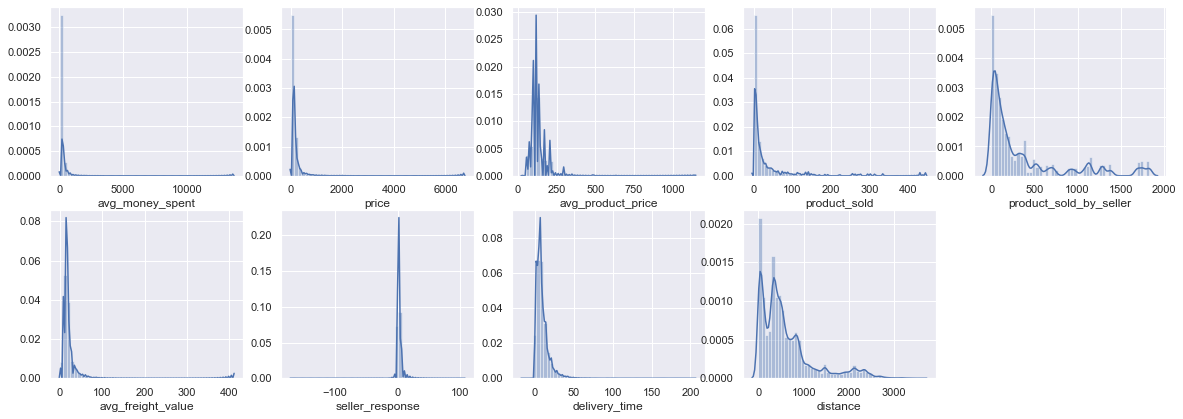

In [158]:
# These are the continuous variables that might have outliers
con_var = final_df[['avg_money_spent', 'price', 'avg_product_price','product_sold', 
            'product_sold_by_seller','avg_freight_value', 'seller_response','delivery_time', 'distance']]

# plot to see distribution before log transform
fig = plt.figure(figsize = (20,18))
for i, item in enumerate(con_var):
    plt.subplot(5,5, i+1)
    sns.distplot(con_var[item])
plt.show;

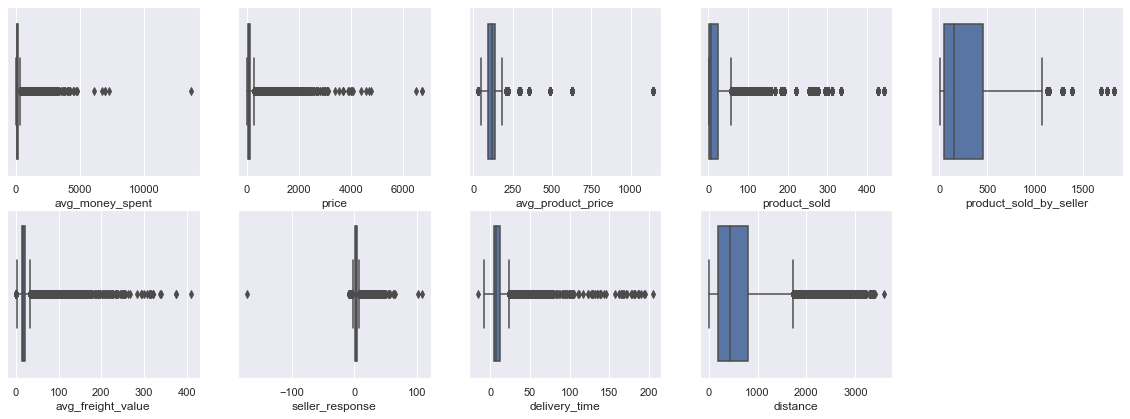

In [159]:
fig = plt.figure(figsize = (20,18))
for i, item in enumerate (con_var):
    plt.subplot(5,5,i+1)
    sns.boxplot(con_var[item])
plt.show;

It is shown that there are negative values under seller_response, delivery_time and avg_freight_value. Negative values under these features are counter intuitive, which will then remove those values before log transform. Moreover, based on the distribution above, it is shown that product_sold_by_seller have a distribution close to normal distribution. Therefore, it is not included to log transform process. 

In [161]:
con_var = con_var[~(con_var['delivery_time'] <= 0)] 
con_var = con_var[~(con_var['seller_response'] <= 0)] 
con_var = con_var[~(con_var['avg_freight_value'] <= 0)] 
con_var = con_var[['avg_money_spent', 'price', 'avg_product_price', 'product_sold', 
                   'avg_freight_value', 'seller_response','delivery_time', 'distance']]

In [162]:
con_var = (con_var+1).transform(np.log)
con_var.fillna(0, inplace = True)

In [163]:
con_var.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92921 entries, 00e7ee1b050b8499577073aeb2a297a1 to b13efaac3f8cb7730ba737059abc614b
Data columns (total 8 columns):
avg_money_spent      92921 non-null float64
price                92921 non-null float64
avg_product_price    92921 non-null float64
product_sold         92921 non-null float64
avg_freight_value    92921 non-null float64
seller_response      92921 non-null float64
delivery_time        92921 non-null float64
distance             92921 non-null float64
dtypes: float64(8)
memory usage: 6.4+ MB


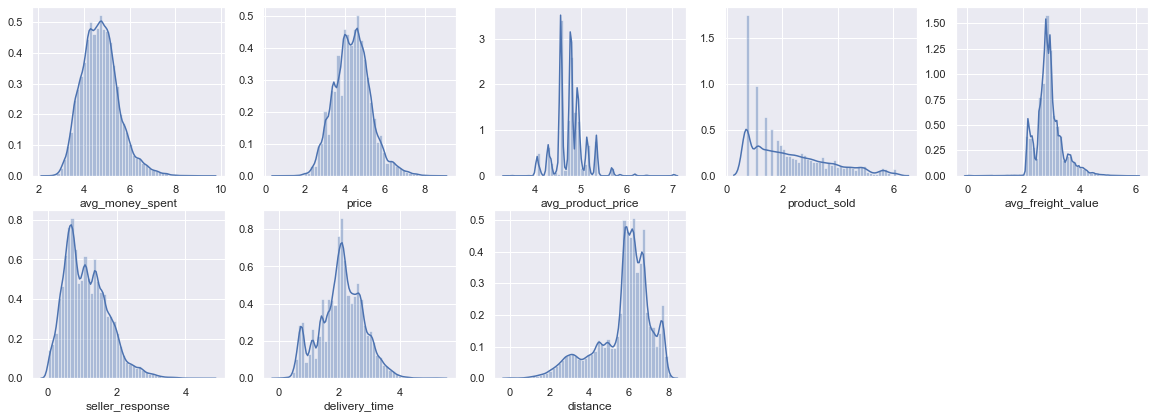

In [164]:
# Plot to check distribution after log transform
fig = plt.figure(figsize = (20,18))
for i, item in enumerate(con_var):
    plt.subplot(5,5,i+1)
    sns.distplot(con_var[item])
plt.show;

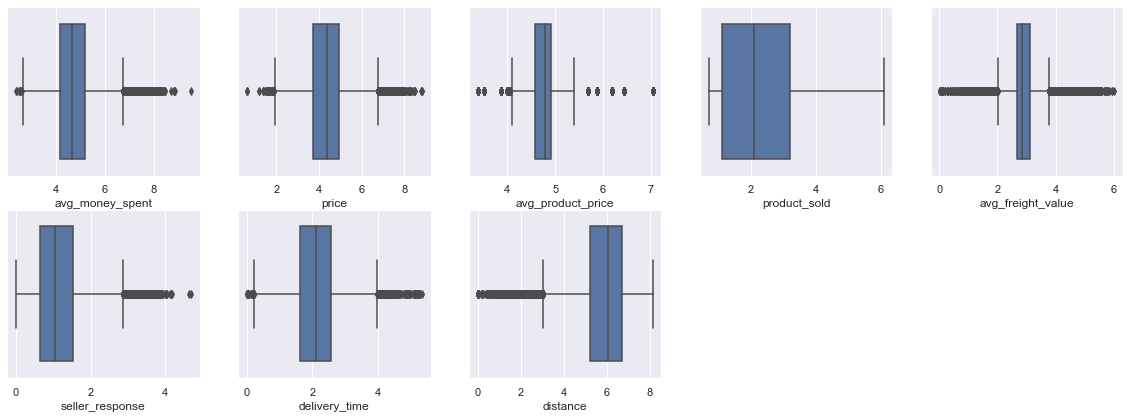

In [165]:
fig = plt.figure(figsize = (20,18))
for i, item in enumerate (con_var):
    plt.subplot(5,5,i+1)
    sns.boxplot(con_var[item])
plt.show;

In [166]:
# merge all transformed columns back into final_df
con_var = con_var.reset_index()
final_df = final_df.reset_index()
final_df = final_df[final_df.order_id.isin(con_var.order_id)]
final_df.set_index('order_id', inplace = True)

In [167]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92921 entries, 00e7ee1b050b8499577073aeb2a297a1 to b13efaac3f8cb7730ba737059abc614b
Data columns (total 30 columns):
review_score              92921 non-null int64
customer_state_comp_1     92921 non-null float64
customer_state_comp_2     92921 non-null float64
customer_state_comp_3     92921 non-null float64
customer_state_comp_4     92921 non-null float64
customer_state_comp_5     92921 non-null float64
no_of_orders              92921 non-null int64
avg_money_spent           92921 non-null float64
avg_product_rating        92921 non-null float64
avg_product_rating_cat    92921 non-null category
product_quality           92921 non-null int64
price                     92921 non-null float64
avg_product_price         92921 non-null float64
product_price             92921 non-null int64
product_sold              92921 non-null int64
seller_state_comp_1       92921 non-null float64
seller_state_comp_2       92921 non-null float64
seller_state_c

### b. Data encoding
There are three types of data, including ordinal categorical variables, binary categorical variables and continuous variable which has not been able to apply log transform. Therefore, further data encoding is needed before feeding data into machine learning algorithms. 

In [168]:
# Convert ordinal categorical variables
ordinal_col = ['avg_product_rating_cat', 'avg_seller_rating_cat']

# Ordinal encoder
for i in ordinal_col:
    final_df[i] = OrdinalEncoder().fit_transform(final_df[[i]])

In [169]:
# Turning categorical data to numeric values

# One hot encoder 
final_df = pd.get_dummies(final_df, columns=['product_quality',\
                                             'product_price', 'delivery_delay'], drop_first = True)

In [170]:
# Turn continuous variables by standard scaler
con_col = ['no_of_orders']

for i in con_col:
    final_df[i] = StandardScaler().fit_transform(final_df[[i]])
    
    print(final_df[i].head())

order_id
00e7ee1b050b8499577073aeb2a297a1   -0.204912
a4866dfc455353f48014a2b9a86608a2   -0.204912
03afb3c10af52ddfa3c33b9881bf43f8   -0.204912
3c75044db750a89606612ed286713eb8   -0.204912
edc9338008f2e9017f842a8bcad3af94   -0.204912
Name: no_of_orders, dtype: float64


In [171]:
# remove irrelevant columns
final_df.drop('avg_product_rating', axis = 1, inplace = True)

In [172]:
final_df.head()

,review_score,customer_state_comp_1,customer_state_comp_2,customer_state_comp_3,customer_state_comp_4,customer_state_comp_5,no_of_orders,avg_money_spent,avg_product_rating_cat,price,...,avg_freight_value,order_status_comp_1,order_status_comp_2,order_status_comp_3,seller_response,delivery_time,distance,product_quality_1,product_price_1,delivery_delay_1
order_id,,,,,,,,,,,,,,,,,,,,,
00e7ee1b050b8499577073aeb2a297a1,4,0.611413,0.014434,-0.045460,0.004208,-0.010326,-0.204912,146.87,3.0,124.99,...,21.88,-0.025241,-0.001949,-0.000461,6.809549,1.991412,346.977593,0,1,1
a4866dfc455353f48014a2b9a86608a2,4,-0.357237,-0.048083,0.317132,-0.081766,0.439485,-0.204912,340.50,3.0,126.99,...,43.26,-0.025241,-0.001949,-0.000461,14.855694,18.987546,1268.842932,0,1,1
03afb3c10af52ddfa3c33b9881bf43f8,4,0.611413,0.014434,-0.045460,0.004208,-0.010326,-0.204912,131.50,3.0,112.99,...,18.51,-0.025241,-0.001949,-0.000461,7.841840,3.212685,51.031812,0,1,1
3c75044db750a89606612ed286713eb8,3,-0.541763,-0.698748,-0.443693,0.024099,-0.052540,-0.204912,174.07,3.0,116.99,...,57.08,-0.025241,-0.001949,-0.000461,13.803403,6.441586,235.039390,0,1,1
edc9338008f2e9017f842a8bcad3af94,5,-0.586156,0.710014,-0.328233,0.020254,-0.045132,-0.204912,140.03,3.0,124.99,...,15.04,-0.025241,-0.001949,-0.000461,13.739363,4.215208,285.975875,0,1,1


### c. Correlation matrix

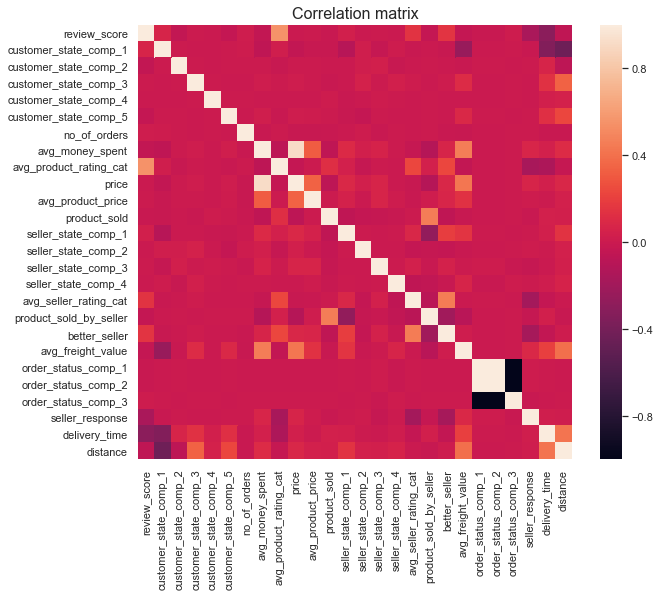

In [173]:
corr = final_df.select_dtypes(include = ['float64', 'int64']).iloc[:,0:].corr()
sns.set(font_scale=1)
plt.figure(figsize=(10,8))
sns.heatmap(corr, vmax=1, square=True)
plt.title('Correlation matrix', fontsize = 16)
plt.show;

In [174]:
corr_list = corr['review_score'].sort_values(axis=0,ascending=False).iloc[1:]
corr_list 

avg_product_rating_cat    0.554610
better_seller             0.151480
avg_seller_rating_cat     0.143704
customer_state_comp_1     0.062726
seller_state_comp_1       0.032443
no_of_orders              0.016558
order_status_comp_3       0.013273
seller_state_comp_3       0.005218
customer_state_comp_3     0.004971
avg_product_price         0.003710
customer_state_comp_4    -0.001208
seller_state_comp_4      -0.004433
seller_state_comp_2      -0.005551
price                    -0.006366
product_sold             -0.008381
order_status_comp_2      -0.013273
order_status_comp_1      -0.013273
customer_state_comp_5    -0.031648
product_sold_by_seller   -0.031788
avg_freight_value        -0.034879
avg_money_spent          -0.042062
customer_state_comp_2    -0.042581
distance                 -0.059771
seller_response          -0.160060
delivery_time            -0.303859
Name: review_score, dtype: float64

 The above correlation matrix showed positive or negative relationship with customer satisfaction. It is shown that some of the independent variables are contradict to the hypothesis. product_sold, product_sold_by_seller are contradict to the hypothesis, which should have a positive relationship with customer satisfaction.

Also, according to the correlation matrix above, avg_money_spent and price have high correlation with each other, whereas avg_money spent are contradict to the hypothesis. Therefore, avg_money_spent will also be dropped before passing data into models.

In [175]:
final_df.drop(['product_sold', 'product_sold_by_seller','avg_money_spent', 'order_status_comp_1', 
              'order_status_comp_2', 'order_status_comp_3'], axis = 1, inplace = True)

### d. Multicollinearity

In [176]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(final_df)

pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)\
.sort_values(ascending = False)

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const                     102.262863
avg_product_rating_cat      2.554278
product_quality_1           2.135882
delivery_time               2.013622
distance                    1.923284
price                       1.755438
delivery_delay_1            1.714248
review_score                1.639654
avg_freight_value           1.520313
product_price_1             1.444008
better_seller               1.381279
customer_state_comp_1       1.368825
avg_seller_rating_cat       1.312174
customer_state_comp_3       1.185340
avg_product_price           1.184718
seller_response             1.136185
customer_state_comp_5       1.092991
seller_state_comp_1         1.089624
customer_state_comp_2       1.020716
seller_state_comp_2         1.016251
seller_state_comp_3         1.016250
seller_state_comp_4         1.013998
customer_state_comp_4       1.005537
no_of_orders                1.001683
dtype: float64

### e. Train test split

In [648]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter

In [178]:
final_df.columns

Index(['review_score', 'customer_state_comp_1', 'customer_state_comp_2',
       'customer_state_comp_3', 'customer_state_comp_4',
       'customer_state_comp_5', 'no_of_orders', 'avg_product_rating_cat',
       'price', 'avg_product_price', 'seller_state_comp_1',
       'seller_state_comp_2', 'seller_state_comp_3', 'seller_state_comp_4',
       'avg_seller_rating_cat', 'better_seller', 'avg_freight_value',
       'seller_response', 'delivery_time', 'distance', 'product_quality_1',
       'product_price_1', 'delivery_delay_1'],
      dtype='object')

In [195]:
feature_cols = final_df.loc[:, final_df.columns != 'review_score'].columns
X = final_df[feature_cols] # Features
y = final_df.review_score # Target variable

In [196]:
# splitting the data into 30% of training, 70% of validation
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size=0.3, random_state=42)
print (X_train.shape, y_train.shape)

(65044, 22) (65044,)


In [197]:
y_test.shape

(27877,)

### f. Class Balance

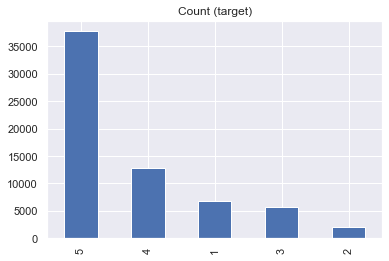

In [198]:
# plot classes distribution
y_train.value_counts().plot(kind='bar', title='Count (target)');

In [199]:
target = y_train
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=4, Count=12807, Percentage=19.690%
Class=3, Count=5642, Percentage=8.674%
Class=5, Count=37826, Percentage=58.154%
Class=1, Count=6697, Percentage=10.296%
Class=2, Count=2072, Percentage=3.186%


In [200]:
from imblearn.over_sampling import SMOTE
smote = SMOTE('not majority', random_state = 42)

X_train, y_train = smote.fit_sample(X_train, y_train)

print (X_train.shape, y_train.shape)

//anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:638: FutureWarning: Pass sampling_strategy=not majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


(189130, 22) (189130,)


In [201]:
target = y_train
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=4, Count=37826, Percentage=20.000%
Class=3, Count=37826, Percentage=20.000%
Class=5, Count=37826, Percentage=20.000%
Class=1, Count=37826, Percentage=20.000%
Class=2, Count=37826, Percentage=20.000%


### 7. Evaluate Algorithms

### Model selection

- Logistic Regression
- Decision Tree
- Random Forest
- AdaBoost
- LightGBM
- Neural Network

In [207]:
import mpl_toolkits

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb

# Confusion Matrix, classification report
from sklearn.metrics import classification_report, confusion_matrix

# Model measurements
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import jaccard_score

# Hyperparemeters tuning
from sklearn.model_selection import RandomizedSearchCV

### a. Baseline Logsitic Regression
Logsitic Regression only designed for binary classification. And since our dataset is multi-class classification, it is neccessary to add fixed param of one-versus-all approach into Logistic Regression for accurate model processing.

In [203]:
logreg = LogisticRegression(multi_class='ovr')

# Train Logistic Regression
logreg.fit(X_train,y_train)

# Perdict the response for test dataset
y_pred = logreg.predict(X_test)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

LogisticRegression(multi_class='ovr')

In [206]:
def model_measurement(y_test, y_pred, model):
    
    model_list = [f1_score, jaccard_score]
    model_score = []
    for i in model_list:
        model_score.append(i(y_test, y_pred, average= 'weighted'))
    accuracy = [accuracy_score(y_test, y_pred)]
    hamming = [hamming_loss(y_test, y_pred)]
    all_models = accuracy + model_score + hamming
    
    index = ['accuracy', 'F1 score', 'Jaccard score', 'Hamming loss']
    model_measurement = pd.DataFrame(all_models, index = index).rename(columns = {0 : model})\
                    .reset_index().rename(columns = {'index':'model_measurement'})
    return model_measurement

In [208]:
baseline_logistic_regression = model_measurement(y_test, y_pred, 'baseline_logistic_regression')
baseline_logistic_regression

,model_measurement,baseline_logistic_regression
0,accuracy,0.573770
1,F1 score,0.561668
2,Jaccard score,0.444447
3,Hamming loss,0.426230


### b. Logsitic regression

In [209]:
logreg = LogisticRegression(multi_class='ovr')

#List of Hyperparameters
penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 1, 10, 100]
max_iter = [100, 1000]
class_weight = ['balanced', None]

#Convert to dictionary
hyperparameters = dict(penalty = penalty, C = C, max_iter = max_iter,
                       class_weight = class_weight)

#Random Search
clf = RandomizedSearchCV(logreg, hyperparameters, random_state=42, cv=3, verbose=1, n_jobs=-1)

best_logreg = clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.4s finished
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

In [210]:
def best_param(model, hyperparameters):
    hyperparameters_list = [*hyperparameters]
    for i in hyperparameters_list:
        print ('Best', i, ':', model.best_estimator_.get_params()[i])

In [211]:
best_param(best_logreg, hyperparameters)

Best penalty : l2
Best C : 0.1
Best max_iter : 100
Best class_weight : balanced


In [212]:
# Rerun Logsitic Regression with best value of parameters
logreg_op = LogisticRegression(penalty = best_logreg.best_estimator_.get_params()['penalty'], 
                C = best_logreg.best_estimator_.get_params()['C'], 
                max_iter = best_logreg.best_estimator_.get_params()['max_iter'], 
                               class_weight = 'balanced',
                multi_class = best_logreg.best_estimator_.get_params()['multi_class'])

# Train Logsitic Regression
logreg_op.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_logreg = logreg_op.predict(X_test)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

LogisticRegression(C=0.1, class_weight='balanced', multi_class='ovr')

In [213]:
optimized_logistic_regression = model_measurement(y_test, y_pred_logreg, 'optimized_logistic_regression')
optimized_logistic_regression

,model_measurement,optimized_logistic_regression
0,accuracy,0.583384
1,F1 score,0.573434
2,Jaccard score,0.461101
3,Hamming loss,0.416616


In [214]:
compare_logreg = baseline_logistic_regression.merge(optimized_logistic_regression, on = 'model_measurement')
compare_logreg

,model_measurement,baseline_logistic_regression,optimized_logistic_regression
0,accuracy,0.573770,0.583384
1,F1 score,0.561668,0.573434
2,Jaccard score,0.444447,0.461101
3,Hamming loss,0.426230,0.416616


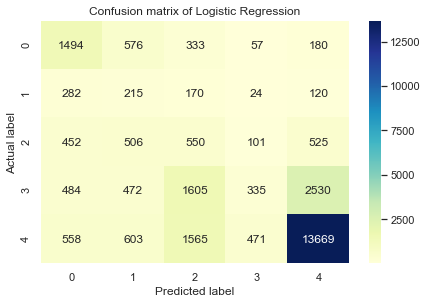

In [215]:
# Plot confusion matrix
logreg_matrix = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(pd.DataFrame(logreg_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix of Logistic Regression', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show;

### c. Decision Tree Classifier

In [216]:
dec_tree_clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
dec_tree_clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dec_tree_clf.predict(X_test)

DecisionTreeClassifier()

In [217]:
decision_tree_before_tuning = model_measurement(y_test, y_pred, 'decision_tree_before_tuning')
decision_tree_before_tuning

,model_measurement,decision_tree_before_tuning
0,accuracy,0.516949
1,F1 score,0.531975
2,Jaccard score,0.386149
3,Hamming loss,0.483051


In [218]:
#List of Hyperparameters 
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_leaf = [1, 2, 4]
max_leaf_nodes = list(range(1,30))
min_samples_split = [2, 5, 10]
max_features= list(range(1,20))
max_features.append(['auto', 'sqrt', 'log2', None])

#Convert to dictionary
hyperparameters = dict(criterion = criterion, splitter = splitter, max_depth = max_depth,\
                       min_samples_leaf = min_samples_leaf, max_leaf_nodes = max_leaf_nodes,\
                       min_samples_split = min_samples_split, max_features= max_features)

#Create new decision tree model
dec_tree = DecisionTreeClassifier()

#Use Random Search
clf = RandomizedSearchCV(dec_tree, hyperparameters, random_state=42, cv=3, verbose=1, n_jobs=-1)

best_dec_tree = clf.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.4s finished


In [219]:
#Print The value of best Hyperparameters
best_param(best_dec_tree, hyperparameters)

Best criterion : gini
Best splitter : best
Best max_depth : None
Best min_samples_leaf : 2
Best max_leaf_nodes : 19
Best min_samples_split : 5
Best max_features : 14


In [220]:
# Rerun Decision Tree Classifier with best value of parameters
dec_tree_op = DecisionTreeClassifier(criterion = best_dec_tree.best_estimator_.get_params()['criterion'], 
            splitter = best_dec_tree.best_estimator_.get_params()['splitter'], 
            max_depth = best_dec_tree.best_estimator_.get_params()['max_depth'], 
            min_samples_leaf = best_dec_tree.best_estimator_.get_params()['min_samples_leaf'], 
            max_leaf_nodes = best_dec_tree.best_estimator_.get_params()['max_leaf_nodes'], 
            min_samples_split = best_dec_tree.best_estimator_.get_params()['min_samples_split'], 
            max_features = best_dec_tree.best_estimator_.get_params()['max_features'])

# Train Decision Tree Classifier
dec_tree_op.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_dectree = dec_tree_op.predict(X_test)

DecisionTreeClassifier(max_features=14, max_leaf_nodes=19, min_samples_leaf=2,
                       min_samples_split=5)

In [221]:
decision_tree_after_tuning = model_measurement(y_test, y_pred_dectree, 'optimized_decision_tree')
decision_tree_after_tuning

,model_measurement,optimized_decision_tree
0,accuracy,0.617570
1,F1 score,0.600412
2,Jaccard score,0.478539
3,Hamming loss,0.382430


In [222]:
compare_dec_tree = decision_tree_before_tuning.merge(decision_tree_after_tuning, on = 'model_measurement')
compare_dec_tree

,model_measurement,decision_tree_before_tuning,optimized_decision_tree
0,accuracy,0.516949,0.617570
1,F1 score,0.531975,0.600412
2,Jaccard score,0.386149,0.478539
3,Hamming loss,0.483051,0.382430


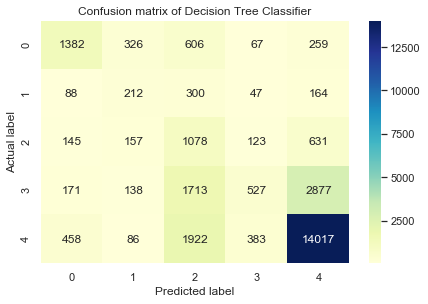

In [223]:
# Plot confusion matrix
des_tree_cnf_matrix = confusion_matrix(y_test, y_pred_dectree)
sns.heatmap(pd.DataFrame(des_tree_cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix of Decision Tree Classifier', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show;

### d. Random Forest

In [224]:
rforest = RandomForestClassifier()

# Train Random Forest Classifier
rforest.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = rforest.predict(X_test)

RandomForestClassifier()

In [225]:
random_forest_before_tuning = model_measurement(y_test, y_pred, 'random_forest_before_tuning')
random_forest_before_tuning

,model_measurement,random_forest_before_tuning
0,accuracy,0.662087
1,F1 score,0.626779
2,Jaccard score,0.497294
3,Hamming loss,0.337913


In [226]:
# Hyperparameters
n_estimators = [30,50,70,90,120,150,200,250,300,350]
max_features = ['auto', 'sqrt']
max_depth = [10,20,30]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

#Convert to dictionary
hyperparameters = dict(n_estimators = n_estimators, max_depth = max_depth,\
                       min_samples_leaf = min_samples_leaf, bootstrap = bootstrap,\
                       min_samples_split = min_samples_split, max_features= max_features)

#Create new Random Forest Classifier model
rforest = RandomForestClassifier()

#Use Random Search
clf = RandomizedSearchCV(rforest, hyperparameters, random_state=42, cv=3, verbose=1, n_jobs=-1)

best_rforest = clf.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.6min finished


In [227]:
best_param(best_rforest, hyperparameters)

Best n_estimators : 200
Best max_depth : 30
Best min_samples_leaf : 1
Best bootstrap : True
Best min_samples_split : 5
Best max_features : sqrt


In [228]:
# Rerun Random Forest Classifier with best value of parameters
rforest_op = RandomForestClassifier(n_estimators = best_rforest.best_estimator_.get_params()['n_estimators'], 
            max_depth = best_rforest.best_estimator_.get_params()['max_depth'], 
            min_samples_leaf = best_rforest.best_estimator_.get_params()['min_samples_leaf'], 
            bootstrap = best_rforest.best_estimator_.get_params()['bootstrap'], 
            min_samples_split = best_rforest.best_estimator_.get_params()['min_samples_split'], 
            max_features = best_rforest.best_estimator_.get_params()['max_features'])

# Train Random Forest Classifier
rforest_op.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_rforest = rforest_op.predict(X_test)

RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=200)

In [229]:
random_forest_after_tuning = model_measurement(y_test, y_pred_rforest, 'optimized_random_forest')
random_forest_after_tuning

,model_measurement,optimized_random_forest
0,accuracy,0.666320
1,F1 score,0.628774
2,Jaccard score,0.499793
3,Hamming loss,0.333680


In [230]:
compare_rforest = random_forest_before_tuning.merge(random_forest_after_tuning, on = 'model_measurement')
compare_rforest

,model_measurement,random_forest_before_tuning,optimized_random_forest
0,accuracy,0.662087,0.666320
1,F1 score,0.626779,0.628774
2,Jaccard score,0.497294,0.499793
3,Hamming loss,0.337913,0.333680


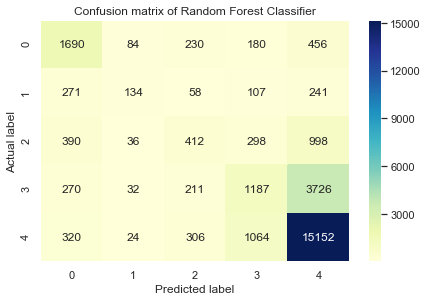

In [231]:
# Plot confusion matrix
rforest_cnf_matrix = confusion_matrix(y_test, y_pred_rforest)
sns.heatmap(pd.DataFrame(rforest_cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix of Random Forest Classifier', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show;

### e. Multi-class AdaBoost Classifier

In [232]:
abc = AdaBoostClassifier()
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [233]:
adaboost_before_tuning = model_measurement(y_test, y_pred, 'adaboost_before_tuning')
adaboost_before_tuning

,model_measurement,adaboost_before_tuning
0,accuracy,0.659504
1,F1 score,0.634129
2,Jaccard score,0.499960
3,Hamming loss,0.340496


In [239]:
# Hyperparameters
n_estimators = [30,50,70,90,120,150,200,250,300,350]
learning_rate = [0.01, 0.1, 0.3, 0.5, 1]

#Convert to dictionary
hyperparameters = dict(n_estimators = n_estimators,\
                      learning_rate = learning_rate)

#Create AdaBoost Classifier model
abc =AdaBoostClassifier()

#Use GridSearch
clf = RandomizedSearchCV(abc, hyperparameters, random_state=42, cv=3, verbose=1, n_jobs=-1)

best_abc = clf.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.9min finished


In [240]:
best_param(best_abc, hyperparameters)

Best n_estimators : 350
Best learning_rate : 0.1


In [241]:
# Rerun AdaBoost Classifier with best value of parameters
abc_op = AdaBoostClassifier(n_estimators = best_abc.best_estimator_.get_params()['n_estimators'], 
                                    learning_rate = best_abc.best_estimator_.get_params()['learning_rate'])

# Train AdaBoost Classifier 
abc_op.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_abc = abc_op.predict(X_test)

AdaBoostClassifier(learning_rate=0.1, n_estimators=350)

In [242]:
adaboost_after_tuning = model_measurement(y_test, y_pred_abc, 'optimized_adaboost')
adaboost_after_tuning

,model_measurement,optimized_adaboost
0,accuracy,0.669764
1,F1 score,0.662246
2,Jaccard score,0.526207
3,Hamming loss,0.330236


In [646]:
compare_abc = adaboost_before_tuning.merge(adaboost_after_tuning, on = 'model_measurement')
compare_abc

,model_measurement,adaboost_before_tuning,optimized_adaboost
0,accuracy,0.664419,0.669907
1,F1 score,0.643928,0.641565
2,Jaccard score,0.507941,0.509078
3,Hamming loss,0.335581,0.330093


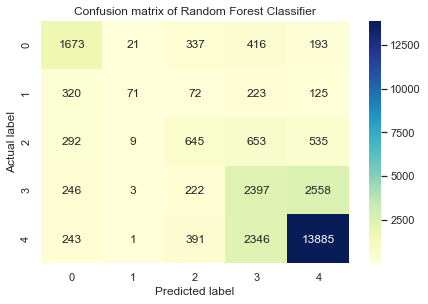

In [244]:
# Plot confusion matrix
abc_cnf_matrix = confusion_matrix(y_test, y_pred_abc)
sns.heatmap(pd.DataFrame(abc_cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix of Random Forest Classifier', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show;

### f. LightGBM


In [245]:
conda install -c conda-forge lightgbm

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [246]:
# turn y_train into 0-4 in order to pass into lgb model
lgb_y_train = (y_train - 1).to_numpy()

In [247]:
# train data with fixed parameters
d_train = lgb.Dataset(X_train, label = lgb_y_train)
params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['num_class'] = 5

clf = lgb.train(params, d_train, 100)

//anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [248]:
#Prediction
y_pred = clf.predict(X_test)

In [249]:
# Turn back into the range of score 1-5
y_pred = [np.argmax(line)+1 for line in y_pred]
np.unique(y_pred)

array([1, 2, 3, 4, 5])

In [250]:
LightGBM_before_tuning = model_measurement(y_test, y_pred, 'LightGBM_before_tuning')
LightGBM_before_tuning

,model_measurement,LightGBM_before_tuning
0,accuracy,0.668185
1,F1 score,0.629401
2,Jaccard score,0.500092
3,Hamming loss,0.331815


In [251]:
# Hyperparameters
cv_params = {'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5],
             'max_depth': [2,4,6,8],
             'num_leaves': [20, 40, 60, 80, 100],
             'feature_fraction': [0.6, 0.65, 0.7, 0.75, 0.8],
             'max_bin': [200, 255, 300, 355, 400]
            }
                    
# Use LightGBM Classifier model with fixed parameters
lgb_clf = lgb.LGBMClassifier(boosting_type = 'gbdt',
                        objective = 'multiclass',
                        metric =  'multi_logloss',
                        num_class = 5,
                        seed = 42)
    
#Use Random Search
clf = RandomizedSearchCV(lgb_clf,cv_params, verbose=2, cv=3,n_jobs = -1,n_iter=10)

best_lgb_clf = clf.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.5min finished


In [252]:
best_param(best_lgb_clf, cv_params)

Best learning_rate : 0.3
Best max_depth : 8
Best num_leaves : 100
Best feature_fraction : 0.65
Best max_bin : 355


In [253]:
# Rerun LightGBM Classifier with best value of parameters
lgb_clf_op = lgb.LGBMClassifier(learning_rate = best_lgb_clf.best_estimator_.get_params()['learning_rate'], 
            max_depth = best_lgb_clf.best_estimator_.get_params()['max_depth'], 
            num_leaves = best_lgb_clf.best_estimator_.get_params()['num_leaves'], 
            feature_fraction = best_lgb_clf.best_estimator_.get_params()['feature_fraction'], 
            max_bin = best_lgb_clf.best_estimator_.get_params()['max_bin'], boosting_type = 'gbdt',
                        objective = 'multiclass',
                        metric =  'multi_logloss',
                        num_class = 5,
                        seed = 42)

# Train LightGBM Classifier
lgb_clf_op.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_lgb = lgb_clf_op.predict(X_test)

LGBMClassifier(feature_fraction=0.65, learning_rate=0.3, max_bin=355,
               max_depth=8, metric='multi_logloss', num_class=5, num_leaves=100,
               objective='multiclass', seed=42)

In [254]:
LightGBM_after_tuning = model_measurement(y_test, y_pred_lgb, 'optimized_LightGBM')
LightGBM_after_tuning

,model_measurement,optimized_LightGBM
0,accuracy,0.664777
1,F1 score,0.621723
2,Jaccard score,0.494307
3,Hamming loss,0.335223


In [255]:
compare_LightGBM = LightGBM_before_tuning.merge(LightGBM_after_tuning, on = 'model_measurement')
compare_LightGBM

,model_measurement,LightGBM_before_tuning,optimized_LightGBM
0,accuracy,0.668185,0.664777
1,F1 score,0.629401,0.621723
2,Jaccard score,0.500092,0.494307
3,Hamming loss,0.331815,0.335223


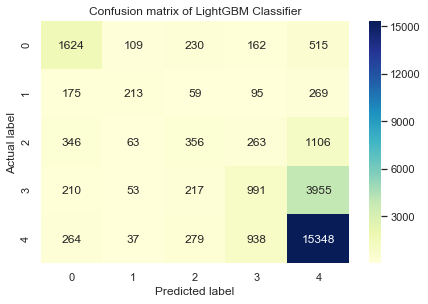

In [256]:
# Plot confusion matrix
lgb_cnf_matrix = confusion_matrix(y_test, y_pred_lgb)
sns.heatmap(pd.DataFrame(lgb_cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix of LightGBM Classifier', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show;

https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

https://www.kaggle.com/prashant111/lightgbm-classifier-in-python

### g. Neural Network

In [257]:
! pip install keras

In [258]:
conda install tensorflow

Solving environment: done

## Package Plan ##

  environment location: //anaconda3

  added / updated specs:
    - tensorflow


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.6.2~ --> pkgs/main::ca-certificates-2020.6.24-0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge::certifi-2020.6.20-py37hc~ --> pkgs/main::certifi-2020.6.20-py37_0
  conda              conda-forge::conda-4.8.3-py37hc8dfbb8~ --> pkgs/main::conda-4.8.3-py37_0
  openssl            conda-forge::openssl-1.1.1g-h0b31af3_1 --> pkgs/main::openssl-1.1.1g-h1de35cc_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# def create_model(learning_rate = 0.01, activation = 'relu'):
  
#     # Create an Adam optimizer with the given learning rate
#     opt = Adam(lr=learning_rate)
    
#     classifier = Sequential()
#     classifier.add(Dense(100, input_dim=22, kernel_initializer='random_normal', activation='relu', \
#                      activity_regularizer = regularizers.l2(1e-5)))
#     classifier.add(Dropout(0.50))
#     classifier.add(Dense(100, kernel_initializer='random_normal', activation='relu',\
#                     activity_regularizer = regularizers.l2(1e-5)))
#     classifier.add(Dropout(0.50))
#     classifier.add(Dense(5, kernel_initializer='random_normal', activation='softmax'))
    
#     classifier.compile(optimizer ='adam',loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True)\
#                    , metrics =['accuracy'])
    
#     return classifier

In [ ]:
# clf_model = KerasClassifier(build_fn = create_model, 
#                        verbose = 0)

# clf_model.fit(X_train, y_train)

# y_pred = clf_model.predict(X_test)

In [ ]:
# model_measurement(y_test, y_pred, 'Neural_network_before_tuning')

In [ ]:
# Define the hyperparameter space

# hyperparameters = {'epochs' : [50, 100, 150],
#                     'batch_size' : [10, 20, 30],
#                     'learning_rate' : [0.01, 0.1, 0.2, 0.3]}

# clf_model = KerasClassifier(build_fn = create_model,
#                        verbose = 0)

# # Create a randomize search cv object 
# nn_model = RandomizedSearchCV(clf_model,
#                                    param_distributions = hyperparameters,
#                                    cv = KFold(10))

# best_nn_model = nn_model.fit(X_train,y_train)

In [ ]:
# clf_model = KerasClassifier(build_fn = create_model, epochs = 100, batch_size = 30, learning_rate = 0.1, 
#                        verbose = 0)

# clf_model.fit(X_train, y_train)

# y_pred = clf_model.predict(X_test)

In [ ]:
# model_measurement(y_test, y_pred, 'Neural_network_after_tuning')

Would like to implement hyperparameter tuning on neural network but it consumes large amount of time (roughly 10-12 hours). Therefore, I gave up on tuning with KerasClassifier.  

In [260]:
# Get the sequential of Nueral Network
classifier = Sequential()
classifier.add(Dense(100, input_dim=22, kernel_initializer='random_normal', activation='relu', \
                     activity_regularizer = regularizers.l2(1e-5)))
classifier.add(Dropout(0.25))
classifier.add(Dense(100, kernel_initializer='random_normal', activation='relu',\
                    activity_regularizer = regularizers.l2(1e-5)))
classifier.add(Dropout(0.25))
classifier.add(Dense(5, kernel_initializer='random_normal', activation='softmax')) 
classifier.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2300      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 12,905
Trainable params: 12,905
Non-trainable params: 0
_________________________________________________________________


In [261]:
#Compiling the neural network
classifier.compile(optimizer ='adam',loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True)\
                   , metrics =['accuracy'])

In [262]:
# convert the range of score 1-5 into 0-4
nn_y_train = (y_train - 1).to_numpy()

In [263]:
# train data
classifier.fit(X_train,nn_y_train, epochs=150, batch_size=20)

Epoch 1/150
189130/189130 [==============================] - 50s 262us/sample - loss: 1.5340 - acc: 0.3289
Epoch 2/150
189130/189130 [==============================] - 47s 247us/sample - loss: 1.5040 - acc: 0.3642
Epoch 3/150
189130/189130 [==============================] - 47s 250us/sample - loss: 1.4995 - acc: 0.3695
Epoch 4/150
189130/189130 [==============================] - 47s 248us/sample - loss: 1.4961 - acc: 0.3729
Epoch 5/150
189130/189130 [==============================] - 47s 251us/sample - loss: 1.4955 - acc: 0.3745
Epoch 6/150
189130/189130 [==============================] - 49s 257us/sample - loss: 1.4955 - acc: 0.3743
Epoch 7/150
189130/189130 [==============================] - 49s 257us/sample - loss: 1.4942 - acc: 0.3747
Epoch 8/150
189130/189130 [==============================] - 49s 260us/sample - loss: 1.4942 - acc: 0.3742
Epoch 9/150
189130/189130 [==============================] - 48s 256us/sample - loss: 1.4939 - acc: 0.3757
Epoch 10/150
189130/189130 [=========

In [264]:
# check test accuracy
test_loss, test_acc = classifier.evaluate(X_train,nn_y_train, verbose=2)
print('\nTest accuracy:', test_acc)

189130/189130 - 9s - loss: 1.4732 - acc: 0.4005

Test accuracy: 0.4005499


In [265]:
# Predict model
probability_model = tensorflow.keras.Sequential([classifier,tensorflow.keras.layers.Softmax()])

predictions = probability_model.predict(X_test)

In [266]:
predictions

array([[0.16113459, 0.19701086, 0.24725766, 0.23346253, 0.16113426],
       [0.16113459, 0.19701086, 0.24725766, 0.23346253, 0.16113426],
       [0.16113459, 0.19701086, 0.24725766, 0.23346253, 0.16113426],
       ...,
       [0.14888361, 0.14888361, 0.14888361, 0.14902468, 0.4043245 ],
       [0.15213975, 0.15213975, 0.15213975, 0.16714197, 0.37643877],
       [0.2439991 , 0.28021368, 0.15859574, 0.15859574, 0.15859574]],
      dtype=float32)

In [267]:
# Each row represents the probability of getting each review score
# argmax row probability to review score and plus 1 to turn back the scale to 1-5
y_pred_nn = np.argmax(predictions, axis=-1)+1

In [268]:
nn_model = model_measurement(y_test, y_pred_nn, 'Neural_network')
nn_model

,model_measurement,Neural_network
0,accuracy,0.581662
1,F1 score,0.568259
2,Jaccard score,0.460726
3,Hamming loss,0.418338


### 8. Model performance evaluation

In [422]:
# Group all model performances into one dataframe
dfs = [compare_logreg, decision_tree_after_tuning, random_forest_after_tuning, adaboost_after_tuning,
       LightGBM_after_tuning, nn_model]
per_compare = reduce(lambda left,right: pd.merge(left,right,on=['model_measurement'], how='outer'), dfs)\
        .set_index('model_measurement')
per_compare

,baseline_logistic_regression,optimized_logistic_regression,optimized_decision_tree,optimized_random_forest,optimized_adaboost,optimized_LightGBM,Neural_network
model_measurement,,,,,,,
accuracy,0.573770,0.583384,0.617570,0.666320,0.669764,0.664777,0.581662
F1 score,0.561668,0.573434,0.600412,0.628774,0.662246,0.621723,0.568259
Jaccard score,0.444447,0.461101,0.478539,0.499793,0.526207,0.494307,0.460726
Hamming loss,0.426230,0.416616,0.382430,0.333680,0.330236,0.335223,0.418338


In [427]:
# Get the rankings of each model evaluation metrics
per_rank = per_compare.copy()
per_rank.iloc[0,:] = per_rank.iloc[0,:].rank(method = 'min', ascending = False)
per_rank.iloc[1,:] = per_rank.iloc[1,:].rank(method = 'min', ascending = False)
per_rank.iloc[2,:] = per_rank.iloc[2,:].rank(method = 'min', ascending = False)
per_rank.iloc[3,:] = per_rank.iloc[3,:].rank(method = 'min')
per_rank

,baseline_logistic_regression,optimized_logistic_regression,optimized_decision_tree,optimized_random_forest,optimized_adaboost,optimized_LightGBM,Neural_network
model_measurement,,,,,,,
accuracy,7.0,5.0,4.0,2.0,1.0,3.0,6.0
F1 score,7.0,5.0,4.0,2.0,1.0,3.0,6.0
Jaccard score,7.0,5.0,4.0,2.0,1.0,3.0,6.0
Hamming loss,7.0,5.0,4.0,2.0,1.0,3.0,6.0


According to all evaluation metrics, all methodologies improved comparing with the baseline Logistic Regression which is a base model that have all default parameters with one-versus-all approach. It is shown that the ranking of all the methodologies are consistent across all evaluation metrics. Both Optimized Logistic Regression and Neural Network have similar performances across all evaluation metrics which are regarded as the poorest models. On the other hand, AdaBoost Classifier performed the best with 1st ranking across all evaluation metrics. Comparing AdaBoost Classifier with Random Forest and LightGBM, although they have similar accuracy score (around 66%), AdaBoost Classifier is around 4% and 3% higher on F1 score and Jaccard score respectively.

### a. Feature importance

### 1. AdaBoost

In [361]:
abc_feature_importance = pd.Series(abc_op.feature_importances_,index=feature_cols).sort_values(ascending=False)\
                .rename('feature_importance_score').to_frame()
abc_feature_importance.head()

,feature_importance_score
avg_product_rating_cat,0.460000
avg_seller_rating_cat,0.334286
delivery_delay_1,0.040000
better_seller,0.028571
product_quality_1,0.022857


### 2. Random Forest

In [353]:
rforest_feature_importance = pd.Series(rforest_op.feature_importances_,index=feature_cols).sort_values(ascending=False)\
                .rename('feature_importance_score').to_frame()
rforest_feature_importance.head()

,feature_importance_score
avg_product_rating_cat,0.135350
distance,0.092029
delivery_time,0.090244
price,0.081867
seller_response,0.073535


### 3. LightGBM

In [376]:
lgb_feature_importance = pd.Series(lgb_clf_op.feature_importances_,index=feature_cols).sort_values(ascending=False)\
                .rename('feature_importance_score').to_frame()
total_score = (pd.Series(lgb_clf_op.feature_importances_,index=feature_cols).sort_values(ascending=False)).sum()
lgb_feature_importance['feature_importance_pct'] = lgb_feature_importance['feature_importance_score']/total_score
lgb_feature_importance = lgb_feature_importance[['feature_importance_pct']].rename(columns = {'feature_importance_pct':
                                                                               'feature_importance_score'})
lgb_feature_importance.head()

,feature_importance_score
distance,0.139344
price,0.116288
avg_freight_value,0.093335
avg_product_price,0.090762
delivery_time,0.087095


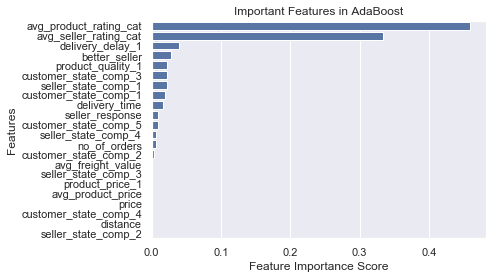

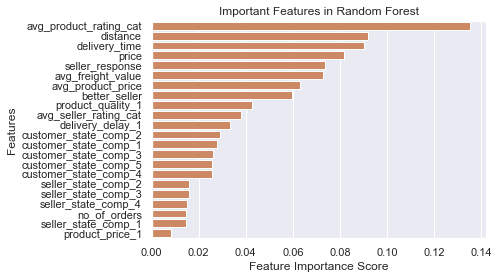

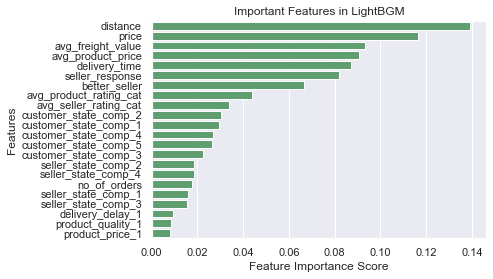

In [377]:
# Plot feature importance of the models to see distribution of features
sns.barplot(x=abc_feature_importance['feature_importance_score'], y=abc_feature_importance.index, color = 'C0')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features in AdaBoost")
plt.show();

sns.barplot(x=rforest_feature_importance['feature_importance_score'], y=rforest_feature_importance.index,\
                                    color = 'C1')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features in Random Forest")
plt.show();

sns.barplot(x=lgb_feature_importance['feature_importance_score'], y=lgb_feature_importance.index, color = 'C2')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features in LightBGM")
plt.show();

In [292]:
feature_importance.index

Index(['avg_product_rating_cat', 'avg_seller_rating_cat', 'delivery_delay_1',
       'better_seller', 'product_quality_1', 'customer_state_comp_3',
       'seller_state_comp_1', 'customer_state_comp_1', 'delivery_time',
       'seller_response', 'customer_state_comp_5', 'seller_state_comp_4',
       'no_of_orders', 'customer_state_comp_2', 'avg_freight_value',
       'seller_state_comp_3', 'product_price_1', 'avg_product_price', 'price',
       'customer_state_comp_4', 'distance', 'seller_state_comp_2'],
      dtype='object')

As we can see that different features have different weightings on models, in order to get a more accurate prediction on customer satisfaction, it is essential to generate four customer satisfaction review score to get the weightings.

### b. Feature weightings

In [378]:
def df_split(feature_importance):
    customer_df = feature_importance.loc[['no_of_orders', 'customer_state_comp_2', 'customer_state_comp_4',
                                'customer_state_comp_5', 'customer_state_comp_1','customer_state_comp_3'], :]

    product_df = feature_importance.loc[['avg_product_price', 'price', 'product_quality_1',\
                                     'avg_product_rating_cat', 'product_price_1'], :]

    seller_df = feature_importance.loc[['seller_response', 'better_seller', 'seller_state_comp_4',
       'seller_state_comp_2', 'seller_state_comp_1', 'seller_state_comp_3', 'avg_seller_rating_cat'], :]

    courier_df = feature_importance.loc[['delivery_time', 'avg_freight_value', 'distance', 'delivery_delay_1'], :]
    
    dfs = [customer_df, product_df, seller_df, courier_df]
    features = ['customer_df', 'product_df', 'seller_df', 'courier_df']
    weightings = []
    for i in dfs:
        i.sort_values('feature_importance_score', ascending = False, inplace = True)
        weightings.append(i['feature_importance_score'].sum())
    
    weight_dict = dict(zip(features, weightings))
    
    return ('weight_dict

In [380]:
# AdaBoost
df_split(abc_feature_importance)

{'customer_df': 0.06,
 'product_df': 0.4828571428571429,
 'seller_df': 0.4,
 'courier_df': 0.05714285714285715}

In [381]:
# Random Forest
df_split(rforest_feature_importance)

{'customer_df': 0.14835279706867954,
 'product_df': 0.33108171072039827,
 'seller_df': 0.23185393034739335,
 'courier_df': 0.2887115618635288}

In [382]:
# LightGBM
df_split(lgb_feature_importance)

{'customer_df': 0.15237034035656402,
 'product_df': 0.26726094003241496,
 'seller_df': 0.2510534846029173,
 'courier_df': 0.3293152350081037}

### c. Train test split for multiple features

In [457]:
X_train_prediction = final_df.drop('review_score', axis = 1).iloc[20000:]
y_train_prediction = final_df['review_score'].iloc[20000:]
X_test_prediction = final_df.drop('review_score', axis = 1).iloc[:20000]
y_test_prediction = final_df['review_score'].iloc[:20000]

X_train_customer = final_df[['no_of_orders', 'customer_state_comp_2', 'customer_state_comp_4',
                            'customer_state_comp_5', 'customer_state_comp_1', 'customer_state_comp_3']].iloc[20000:]
y_train_customer = final_df['review_score'].iloc[20000:]
X_test_customer = final_df[['no_of_orders', 'customer_state_comp_2', 'customer_state_comp_4',
                            'customer_state_comp_5', 'customer_state_comp_1', 'customer_state_comp_3']].iloc[:20000]
y_test_customer = final_df['review_score'].iloc[:20000]

X_train_product = final_df[['avg_product_price', 'price', 'product_quality_1',
                'avg_product_rating_cat', 'product_price_1']].iloc[20000:]
y_train_product = final_df['review_score'].iloc[20000:]
X_test_product = final_df[['avg_product_price', 'price', 'product_quality_1',
                'avg_product_rating_cat', 'product_price_1']].iloc[:20000]
y_test_product = final_df['review_score'].iloc[:20000]

X_train_seller = final_df[['seller_response', 'better_seller', 'seller_state_comp_4','seller_state_comp_2', 
                        'seller_state_comp_1', 'seller_state_comp_3','avg_seller_rating_cat']].iloc[20000:]
y_train_seller = final_df['review_score'].iloc[20000:]
X_test_seller = final_df[['seller_response', 'better_seller', 'seller_state_comp_4','seller_state_comp_2', 
                        'seller_state_comp_1', 'seller_state_comp_3','avg_seller_rating_cat']].iloc[:20000]
y_test_seller = final_df['review_score'].iloc[:20000]

X_train_courier = final_df[['delivery_time', 'avg_freight_value', 'distance', 'delivery_delay_1']].iloc[20000:]
y_train_courier = final_df['review_score'].iloc[20000:]
X_test_courier = final_df[['delivery_time', 'avg_freight_value', 'distance', 'delivery_delay_1']].iloc[:20000]
y_test_courier = final_df['review_score'].iloc[:20000]

### d. Class Balance

In [458]:
def class_dis(y_train_feature, model):
    counter = Counter(y_train_feature)
    print(model,':')
    for k,v in counter.items():
        per = v / len(target) * 100
        print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

In [459]:
class_dis(y_train_prediction, 'prediction')
class_dis(y_train_customer, 'customer')
class_dis(y_train_product, 'product')
class_dis(y_train_seller, 'seller')
class_dis(y_train_courier, 'courier')

prediction :
Class=5, Count=43460, Percentage=22.979%
Class=4, Count=14270, Percentage=7.545%
Class=3, Count=5863, Percentage=3.100%
Class=1, Count=7155, Percentage=3.783%
Class=2, Count=2173, Percentage=1.149%
customer :
Class=5, Count=43460, Percentage=22.979%
Class=4, Count=14270, Percentage=7.545%
Class=3, Count=5863, Percentage=3.100%
Class=1, Count=7155, Percentage=3.783%
Class=2, Count=2173, Percentage=1.149%
product :
Class=5, Count=43460, Percentage=22.979%
Class=4, Count=14270, Percentage=7.545%
Class=3, Count=5863, Percentage=3.100%
Class=1, Count=7155, Percentage=3.783%
Class=2, Count=2173, Percentage=1.149%
seller :
Class=5, Count=43460, Percentage=22.979%
Class=4, Count=14270, Percentage=7.545%
Class=3, Count=5863, Percentage=3.100%
Class=1, Count=7155, Percentage=3.783%
Class=2, Count=2173, Percentage=1.149%
courier :
Class=5, Count=43460, Percentage=22.979%
Class=4, Count=14270, Percentage=7.545%
Class=3, Count=5863, Percentage=3.100%
Class=1, Count=7155, Percentage=3.7

In [460]:
smote = SMOTE('not majority', random_state = 42)

X_train_prediction, y_train_prediction = smote.fit_sample(X_train_prediction, y_train_prediction)
X_train_customer, y_train_customer = smote.fit_sample(X_train_customer, y_train_customer)
X_train_product, y_train_product = smote.fit_sample(X_train_product, y_train_product)
X_train_seller, y_train_seller = smote.fit_sample(X_train_seller, y_train_seller)
X_train_courier, y_train_courier = smote.fit_sample(X_train_courier, y_train_courier)

//anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:638: FutureWarning: Pass sampling_strategy=not majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


In [461]:
class_dis(y_train_prediction, 'prediction')
class_dis(y_train_customer, 'customer')
class_dis(y_train_product, 'product')
class_dis(y_train_seller, 'seller')
class_dis(y_train_courier, 'courier')

prediction :
Class=5, Count=43460, Percentage=22.979%
Class=4, Count=43460, Percentage=22.979%
Class=3, Count=43460, Percentage=22.979%
Class=1, Count=43460, Percentage=22.979%
Class=2, Count=43460, Percentage=22.979%
customer :
Class=5, Count=43460, Percentage=22.979%
Class=4, Count=43460, Percentage=22.979%
Class=3, Count=43460, Percentage=22.979%
Class=1, Count=43460, Percentage=22.979%
Class=2, Count=43460, Percentage=22.979%
product :
Class=5, Count=43460, Percentage=22.979%
Class=4, Count=43460, Percentage=22.979%
Class=3, Count=43460, Percentage=22.979%
Class=1, Count=43460, Percentage=22.979%
Class=2, Count=43460, Percentage=22.979%
seller :
Class=5, Count=43460, Percentage=22.979%
Class=4, Count=43460, Percentage=22.979%
Class=3, Count=43460, Percentage=22.979%
Class=1, Count=43460, Percentage=22.979%
Class=2, Count=43460, Percentage=22.979%
courier :
Class=5, Count=43460, Percentage=22.979%
Class=4, Count=43460, Percentage=22.979%
Class=3, Count=43460, Percentage=22.979%
Clas

### e. Model prediction

### 1. Random Forest prediction

In [462]:
rforest_prediction_model = RandomForestClassifier(n_estimators = 200, max_depth = 30, min_samples_leaf = 1, bootstrap = True, 
                       min_samples_split = 5,max_features = 'sqrt')

rforest_prediction_model.fit(X_train_prediction, y_train_prediction)

RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=200)

In [463]:
rforest_customer_model = RandomForestClassifier(n_estimators = 200, max_depth = 30, min_samples_leaf = 1, bootstrap = True, 
                       min_samples_split = 5,max_features = 'sqrt')

rforest_customer_model.fit(X_train_customer, y_train_customer)

RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=200)

In [464]:
rforest_product_model = RandomForestClassifier(n_estimators = 200, max_depth = 30, min_samples_leaf = 1, bootstrap = True, 
                       min_samples_split = 5,max_features = 'sqrt')

rforest_product_model.fit(X_train_product, y_train_product)

RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=200)

In [465]:
rforest_seller_model = RandomForestClassifier(n_estimators = 200, max_depth = 30, min_samples_leaf = 1, bootstrap = True, 
                       min_samples_split = 5,max_features = 'sqrt')

rforest_seller_model.fit(X_train_seller, y_train_seller)

RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=200)

In [466]:
rforest_courier_model = RandomForestClassifier(n_estimators = 200, max_depth = 30, min_samples_leaf = 1, bootstrap = True, 
                       min_samples_split = 5,max_features = 'sqrt')

rforest_courier_model.fit(X_train_courier, y_train_courier)

RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=200)

In [467]:
print('RandomForestClassifier score on prediction:',rforest_prediction_model.score(X_train_prediction, y_train_prediction))
print('RandomForestClassifier score on customer:',rforest_customer_model.score(X_train_customer, y_train_customer))
print('RandomForestClassifier score on product:',rforest_product_model.score(X_train_product, y_train_product))
print('RandomForestClassifier score on seller:',rforest_seller_model.score(X_train_seller, y_train_seller))
print('RandomForestClassifier score on courier:',rforest_courier_model.score(X_train_courier, y_train_courier))

RandomForestClassifier score on prediction: 0.977436723423838
RandomForestClassifier score on customer: 0.23825126553152323
RandomForestClassifier score on product: 0.7731477220432582
RandomForestClassifier score on seller: 0.8719282098481362
RandomForestClassifier score on courier: 0.9883064887252646


### 2. AdaBoost prediction

In [468]:
abc_prediction_model = AdaBoostClassifier(learning_rate=0.1, n_estimators=350)

abc_prediction_model.fit(X_train_prediction, y_train_prediction)

AdaBoostClassifier(learning_rate=0.1, n_estimators=350)

In [469]:
abc_customer_model = AdaBoostClassifier(learning_rate=0.1, n_estimators=350)

abc_customer_model.fit(X_train_customer, y_train_customer)

AdaBoostClassifier(learning_rate=0.1, n_estimators=350)

In [470]:
abc_product_model = AdaBoostClassifier(learning_rate=0.1, n_estimators=350)

abc_product_model.fit(X_train_product, y_train_product)

AdaBoostClassifier(learning_rate=0.1, n_estimators=350)

In [471]:
abc_seller_model = AdaBoostClassifier(learning_rate=0.1, n_estimators=350)

abc_seller_model.fit(X_train_seller, y_train_seller)

AdaBoostClassifier(learning_rate=0.1, n_estimators=350)

In [472]:
abc_courier_model = AdaBoostClassifier(learning_rate=0.1, n_estimators=350)

abc_courier_model.fit(X_train_courier, y_train_courier)

AdaBoostClassifier(learning_rate=0.1, n_estimators=350)

In [473]:
print('AdaBoostClassifier score on prediction:',abc_prediction_model.score(X_train_prediction, y_train_prediction))
print('AdaBoostClassifier score on customer:',abc_customer_model.score(X_train_customer, y_train_customer))
print('AdaBoostClassifier score on product:',abc_product_model.score(X_train_product, y_train_product))
print('AdaBoostClassifier score on seller:',abc_seller_model.score(X_train_seller, y_train_seller))
print('AdaBoostClassifier score on courier:',abc_courier_model.score(X_train_courier, y_train_courier))

AdaBoostClassifier score on prediction: 0.5031845375057524
AdaBoostClassifier score on customer: 0.22919466175793834
AdaBoostClassifier score on product: 0.44085135757017946
AdaBoostClassifier score on seller: 0.26327197422917625
AdaBoostClassifier score on courier: 0.3013805798435343


### 3. LightBGM prediction

In [474]:
lgb_prediction_model = lgb.LGBMClassifier(boosting_type = 'gbdt', objective = 'multiclass', 
                             metric =  'multi_logloss',num_class = 5,
                            seed = 42, learning_rate = 0.3, max_depth = 8, 
                             num_leaves = 100, feature_fraction = 0.65, max_bin = 355)
    
lgb_prediction_model.fit(X_train_prediction, y_train_prediction)

LGBMClassifier(feature_fraction=0.65, learning_rate=0.3, max_bin=355,
               max_depth=8, metric='multi_logloss', num_class=5, num_leaves=100,
               objective='multiclass', seed=42)

In [475]:
lgb_customer_model = lgb.LGBMClassifier(boosting_type = 'gbdt', objective = 'multiclass', 
                             metric =  'multi_logloss',num_class = 5,
                            seed = 42, learning_rate = 0.3, max_depth = 8, 
                             num_leaves = 100, feature_fraction = 0.65, max_bin = 355)

lgb_customer_model.fit(X_train_customer, y_train_customer)

LGBMClassifier(feature_fraction=0.65, learning_rate=0.3, max_bin=355,
               max_depth=8, metric='multi_logloss', num_class=5, num_leaves=100,
               objective='multiclass', seed=42)

In [476]:
lgb_product_model = lgb.LGBMClassifier(boosting_type = 'gbdt', objective = 'multiclass', 
                             metric =  'multi_logloss',num_class = 5,
                            seed = 42, learning_rate = 0.3, max_depth = 8, 
                             num_leaves = 100, feature_fraction = 0.65, max_bin = 355)
    
lgb_product_model.fit(X_train_product, y_train_product)

LGBMClassifier(feature_fraction=0.65, learning_rate=0.3, max_bin=355,
               max_depth=8, metric='multi_logloss', num_class=5, num_leaves=100,
               objective='multiclass', seed=42)

In [477]:
lgb_seller_model = lgb.LGBMClassifier(boosting_type = 'gbdt', objective = 'multiclass', 
                             metric =  'multi_logloss',num_class = 5,
                            seed = 42, learning_rate = 0.3, max_depth = 8, 
                             num_leaves = 100, feature_fraction = 0.65, max_bin = 355)
    
lgb_seller_model.fit(X_train_seller, y_train_seller)

LGBMClassifier(feature_fraction=0.65, learning_rate=0.3, max_bin=355,
               max_depth=8, metric='multi_logloss', num_class=5, num_leaves=100,
               objective='multiclass', seed=42)

In [478]:
lgb_courier_model = lgb.LGBMClassifier(boosting_type = 'gbdt', objective = 'multiclass', 
                             metric =  'multi_logloss',num_class = 5,
                            seed = 42, learning_rate = 0.3, max_depth = 8, 
                             num_leaves = 100, feature_fraction = 0.65, max_bin = 355)

lgb_courier_model.fit(X_train_courier, y_train_courier)

LGBMClassifier(feature_fraction=0.65, learning_rate=0.3, max_bin=355,
               max_depth=8, metric='multi_logloss', num_class=5, num_leaves=100,
               objective='multiclass', seed=42)

In [479]:
print('LGBMClassifier score on prediction:',lgb_prediction_model.score(X_train_prediction, y_train_prediction))
print('LGBMClassifier score on customer:',lgb_customer_model.score(X_train_customer, y_train_customer))
print('LGBMClassifier score on product:',lgb_product_model.score(X_train_product, y_train_product))
print('LGBMClassifier score on seller:',lgb_seller_model.score(X_train_seller, y_train_seller))
print('LGBMClassifier score on courier:',lgb_courier_model.score(X_train_courier, y_train_courier))

LGBMClassifier score on prediction: 0.7810538426138979
LGBMClassifier score on customer: 0.2378554993097101
LGBMClassifier score on product: 0.5788541187298666
LGBMClassifier score on seller: 0.4822227335480902
LGBMClassifier score on courier: 0.5457017947537965


### e. Weighted performance of Random Forest Classifier

In [420]:
def weighted_performance(i):
    weighted_score = (rforest_customer_model.predict([X_test_customer.iloc[i]]).astype(int))* 0.14835279706867954+\
                    (rforest_product_model.predict([X_test_product.iloc[i]]).astype(int))* 0.33108171072039827+\
                    (rforest_seller_model.predict([X_test_seller.iloc[i]]).astype(int))* 0.23185393034739335+\
                    (rforest_courier_model.predict([X_test_courier.iloc[i]]).astype(int))*0.2887115618635288
    return weighted_score

In [421]:
for i in range (100, 200,10):
    print('index ',i)
    print('actual review score:', y_test_prediction.iloc[i])
    print('rating prediction: ', rforest_prediction_model.predict([X_test_prediction.iloc[i]]))
    print('customer features: ', rforest_customer_model.predict([X_test_customer.iloc[i]]))
    print('product performance: ', rforest_product_model.predict([X_test_product.iloc[i]]))
    print('seller performance: ', rforest_seller_model.predict([X_test_seller.iloc[i]]))
    print('courier performance: ', rforest_courier_model.predict([X_test_courier.iloc[i]]))
    print('weighted score: ', weighted_performance(i))
    print('----------------------------------------------------------------------------')


index  100
actual review score: 4
rating prediction:  [4]
customer features:  [5]
product performance:  [4]
seller performance:  [5]
courier performance:  [5]
weighted score:  [4.66891829]
----------------------------------------------------------------------------
index  110
actual review score: 5
rating prediction:  [1]
customer features:  [5]
product performance:  [4]
seller performance:  [5]
courier performance:  [4]
weighted score:  [4.38020673]
----------------------------------------------------------------------------
index  120
actual review score: 4
rating prediction:  [3]
customer features:  [5]
product performance:  [4]
seller performance:  [5]
courier performance:  [5]
weighted score:  [4.66891829]
----------------------------------------------------------------------------
index  130
actual review score: 5
rating prediction:  [4]
customer features:  [5]
product performance:  [4]
seller performance:  [5]
courier performance:  [5]
weighted score:  [4.66891829]
-------------